In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
filtered_gt_path = "/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/dataset/filtered_ground_truth.json"
old_gt_path = "/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/dataset/ground_truth.json"
csv_dir = "/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/dataset/"

with open(filtered_gt_path, 'r') as f:
    filtered_data = json.load(f)

with open(old_gt_path, 'r') as f:
    old_gt = json.load(f)

q3_cat_ind = pd.read_csv(f'{csv_dir}cat_ind_q3.csv')
q3_cat_test_ins = pd.read_csv(f'{csv_dir}cat_test_ins_q3.csv')
q3_merged = pd.merge(q3_cat_ind, q3_cat_test_ins, on='Category', how='outer')
q3_merged.to_csv(f'{csv_dir}q3_merged.csv', index=False)

q5_cat_hist = pd.read_csv(f'{csv_dir}cat_ind_q5.csv')
q5_cat_test_hist = pd.read_csv(f'{csv_dir}cat_test_ins_q5.csv')
q5_merged = pd.merge(q5_cat_hist, q5_cat_test_hist, on='Category', how='outer')
q5_merged.to_csv(f'{csv_dir}q5_merged.csv', index=False)

In [3]:
def is_in_age_range(age_value, target_ranges):
    age_value = int(age_value)
    for min_age, max_age in target_ranges:
        if min_age == 0 and max_age == 0:
            if age_value == 0:
                return True
        elif min_age <= age_value <= max_age:
            return True
    return False

def get_answers(sample_patient_dict):
    case_id = sample_patient_dict["case_id"]
    insurance = sample_patient_dict["insurance"]
    genetic_tests = sample_patient_dict["genetic_tests"]
    age = sample_patient_dict["age_years"]
    order_provider = sample_patient_dict["order_provider"]
    clinical_indication = sample_patient_dict["clinical_indication"]
    prior_testing = sample_patient_dict["prior_testing"]
    family_history = sample_patient_dict["family_history"]
    genetic_counselor = sample_patient_dict["genetic_counselor"]

    q0 = q1 = q2 = q3 = q4 = q5 = q6 = q7 = q8 = "Not Specified"

    # Q0 - genetic tests
    if genetic_tests.startswith('CMA'):
        q0 = "CMA"
    else:
        q0 = genetic_tests
    
    # Q1 - age criteria
    if insurance == "BCBS_FEP":
        if genetic_tests in ["WES", "WGS"]:
            if age == -1:
                q1 = "Not Specified"
            elif age <= 18:
                q1 = "Yes"
            else:
                q1 = "No"
        elif genetic_tests == "CMA":
            if age == -1:
                q1 = "Not Specified"
            elif age <= 18:
                q1 = "Yes"
            else:
                q1 = "No"
        elif genetic_tests == "BRCA1/2":
            if age == -1 or age < 18:
                q1 = "No"
            else:
                if clinical_indication in bcbs_brca_age_indications:
                    required_age = bcbs_brca_age_indications[clinical_indication]
                    if isinstance(required_age, tuple):
                        if required_age[0] <= age <= required_age[1]:
                            q1 = "Yes"
                    else:
                        if age <= required_age:
                            q1 = "Yes"
                elif clinical_indication in bcbs_brca_no_age_indications:
                    q1 = "Yes"
            
                if q1 == "Not Specified" and family_history in bcbs_brca_family_indications:
                    q1 = "Yes"
            
    
    elif insurance == "UHC":
        if genetic_tests in ["WES", "WGS"]:
            if age == -1:
                q1 = "Yes" if genetic_tests == "WES" else "No"
            elif clinical_indication in uhc_diagnosed_age_indications:
                required_age = uhc_diagnosed_age_indications[clinical_indication]
                q1 = "Yes" if age <= required_age else "Not Specified"
            else:
                q1 = "Not Specified"
                
        elif genetic_tests == "CMA":
            if age == -1:
                q1 = "Yes"
            elif clinical_indication in uhc_cma_dignosed_age_indications:
                required_age = uhc_cma_dignosed_age_indications[clinical_indication]
                q1 = "Yes" if age <= required_age else "Not Specified"
            else:
                q1 = "Not Specified"

        elif genetic_tests == "BRCA1/2":
            if clinical_indication in uhc_brca_age_indications:
                if age <= 50:
                    q1 = "Yes"
            elif clinical_indication in uhc_brca_indications:
                if age <= 65:
                    q1 = "Yes"
            if q1 == "Not Specified" and family_history in uhc_brca_family_indications:
                q1 = "Yes"

    
    elif insurance == "Cigna":
        if genetic_tests in ["WES", "WGS"]:
            if age == -1:
                q1 = "Yes" if genetic_tests == "WES" else "No"
            else:
                if age >= 21:
                    q1 = "No"
                else:
                    if clinical_indication in cigna_diagnosed_age_indications:
                        required_age = cigna_diagnosed_age_indications[clinical_indication]
                        if age <= required_age:
                            q1 = "Yes"
                        else:
                            q1 = "Not Specified"
                    else:
                        q1 = "Yes"
                        
        elif genetic_tests == "BRCA1/2":
            if age == -1 or age < 18:
                q1 = "No"
            else:
                if clinical_indication in cigna_brca_age_indications:
                    required_age = cigna_brca_age_indications[clinical_indication]
                    if age <= required_age:
                        q1 = "Yes"
                elif clinical_indication in cigna_brca_indications:
                    q1 = "Yes"
                if q1 == "Not Specified" and family_history in cigna_brca_family_indications:
                    q1 = "Yes"
            
        elif genetic_tests == "CMA_developmental_disorder":
            q1 = "Yes" if age == 0 else "No"
    
    # Q2 - order provider
    if insurance == "UHC" and genetic_tests in ["WES", "WGS"]:
        approved_providers = ["Neurologist", "Medical Geneticist", "Neonatologist", "Developmental Pediatrician"]
        q2 = "Yes" if order_provider in approved_providers else "No"
    
    # Q3 - clinical indication
    mask_test = (q3_merged['Test'] == genetic_tests)
    mask_ind = (q3_merged['Indication'] == clinical_indication)
    mask_ins = (q3_merged['Insurance'] == insurance)
    
    full_match = len(q3_merged[mask_test & mask_ind & mask_ins]) > 0
    test_insurance_combo = len(q3_merged[mask_test & mask_ins]) > 0
    
    if full_match:
        q3 = "Yes"
    elif test_insurance_combo:
        q3 = "No"
    else:
        q3 = "Not Specified"
    
    # Q4 - prior testing
    if genetic_tests in ["WES", "WGS"]:
        q4 = "Yes" if prior_testing in ["CMA", "Fragile X testing", "FISH testing", "Karyotype testing"] else "No"
    
    # Q5 - family history
    mask_test = (q5_merged['Test'] == genetic_tests)
    mask_fh = (q5_merged['Family history'] == family_history)
    mask_ins = (q5_merged['Insurance'] == insurance)
    
    full_match = len(q5_merged[mask_test & mask_fh & mask_ins]) > 0
    test_insurance_combo = len(q5_merged[mask_test & mask_ins]) > 0
    
    if full_match:
        q5 = "Yes"
    elif test_insurance_combo:
        q5 = "No"
    else:
        q5 = "Not Specified"
    
    # Q6 - genetic counselor
    approved_counseling = [
        "Saw a genetic counselor before testing and will visit after results are received",
        "Saw a genetic counselor multiple times",
        "discussed with a genetic specialist"
    ]
    
    if insurance == "BCBS_FEP" and genetic_tests in ["BRCA1/2", "WES", "WGS"]:
        q6 = "Yes" if genetic_counselor in approved_counseling else "No"
    elif insurance == "Cigna" and genetic_tests in ["BRCA1/2", "CMA_developmental_disorder"]:
        q6 = "Yes" if genetic_counselor in approved_counseling else "No"
    
    # Q7 - CPT code
    cpt_mapping = {
        "WES": "81415", "WGS": "81425", "BRCA1/2": "81162",
        "CMA": "81228", "CMA_developmental_disorder": "81228", "CMA_tumor": "81277"
    }
    
    if insurance in ["UHC", "Cigna"]:
        if q0 == "CMA":
            if insurance == "UHC" and genetic_tests == "CMA_tumor":
                q7 = cpt_mapping.get("CMA")
            elif insurance == "Cigna" and genetic_tests == "CMA":
                q7 = "Not Specified"
            else:
                q7 = cpt_mapping.get(genetic_tests)
        else:
            q7 = cpt_mapping.get(q0)
    
    # Q8 - final decision
    all_answers = [q1, q2, q3, q4, q5, q6]
    q8 = "No" if "No" in all_answers else "Yes"
    
    return {
        "Q0": q0, "Q1": q1, "Q2": q2, "Q3": q3,
        "Q4": q4, "Q5": q5, "Q6": q6, "Q7": q7, "Q8": q8
    }

uhc_diagnosed_age_indications = {
    "Moderate, severe, or profound Intellectual Disability diagnosed by 18 years of age": 18,
    "Epileptic encephalopathy with onset before three years of age": 3,
    "Global Developmental Delay": 5,
    "Global developmental delay": 5,
    "Unexplained epileptic encephalopathy (onset before three years of age) and no prior epilepsy multigene panel testing performed": 3,
    "Significant hearing or visual impairment diagnosed by 18 years of age": 18,
    "Developmental Delay/Intellectual Disability where a specific syndrome is not suspected": 18
}

uhc_cma_dignosed_age_indications = {
    "Global developmental delay": 5,
    "Global Developmental Delay": 5,
    "Moderate, severe, or profound Intellectual Disability diagnosed by 18 years of age": 18,
    "Developmental Delay/Intellectual Disability where a specific syndrome is not suspected": 18
}

cigna_diagnosed_age_indications = {
    "Moderate, severe, or profound Intellectual Disability diagnosed by 18 years of age": 18,
    "Epileptic encephalopathy with onset before three years of age": 3,
    "Unexplained epileptic encephalopathy (onset before three years of age) and no prior epilepsy multigene panel testing performed": 3,
    "Global developmental delay": 5,
    "Global Developmental Delay": 5,
    "Developmental Delay/Intellectual Disability where a specific syndrome is not suspected": 18
}

bcbs_brca_age_indications = {
    "Diagnosed breast cancer at age equal to under 45": 45,
    "Personal history of breast cancer diagnosed between ages 46 and 50 with an additional primary breast cancer at any age": (46, 50),
    "Multiple primary Breast Cancers (as a prior diagnosis or as a bilateral primary cancer)": (46, 50),
    "Breast Cancer and Unknown or Limited Family History": (46, 50),
    "Personal history of breast cancer diagnosed between ages 46 and 50 with at least one close relative diagnosed with breast, ovarian, pancreatic, or prostate cancer at any age": (46, 50),
    "Personal history of breast cancer diagnosed equal and under 60 with Triple-negative breast cancer": 60,
    "Personal history of breast cancer diagnosed any age with at least one close relative with breast cancer diagnosed at age equal to under 50 years": 50,
    "Female with breast cancer diagnosis 50 years of age or younger": 50,
    "Breast cancer diagnosed at age 50 or younger": 50,
    "Triple-negative breast cancer": 60
}

bcbs_brca_no_age_indications = {
    "Diagnosed with two or more primary breast cancers at any age": None,
    "Diagnosed at any age with triple negative breast cancer (i.e., estrogen receptornegative (ER-), progesterone receptor negative (PR-), and human epidermal growth factor receptor negative (HER2-) breast cancer)": None,
    "Male with breast cancer at any age": None,
    "Metastatic Breast Cancer": None,
    "Breast Cancer and individual was assigned male at birth": None,
    "Personal history of breast cancer diagnosed any age with at least one close relative with ovarian carcinoma": None,
    "Personal history of epithelial ovarian carcinoma (including fallopian tube cancer or peritoneal cancer) at any age": None,
    "Epithelial ovarian, fallopian tube, or primary peritoneal cancer diagnosis at any age": None,
    "Personal history of breast cancer diagnosed any age with at least one close relative with pancreatic cancer": None,
    "Personal history of exocrine pancreatic cancer at any age": None,
    "Exocrine pancreatic cancer": None,
    "Pancreatic cancer at any age": None,
    "Personal history of breast cancer diagnosed any age with at least one close relative with Metastatic or intraductal/cribriform prostate cancer": None,
    "Personal history of metastatic or intraductal/cribriform histology prostate cancer at any age": None,
    "Prostate cancer at any age with metastatic, intraductal/cribriform histology, high-risk, or very-high-risk group": None,
    "Metastatic prostate cancer": None
}

bcbs_brca_family_indications = q5_merged[
    (q5_merged['Test'] == 'BRCA1/2') & 
    (q5_merged['Insurance'] == 'BCBS_FEP')
]['Family history'].tolist()


uhc_brca_indications = q3_merged[
    (q3_merged['Test'] == 'BRCA1/2') & 
    (q3_merged['Insurance'] == 'UHC')
]['Indication'].tolist()

uhc_brca_age_indications = {
    "Diagnosed breast cancer at age equal to under 45": 50,
    "Personal history of breast cancer diagnosed between ages 46 and 50 with an additional primary breast cancer at any age": 50,
    "Female with breast cancer diagnosis 50 years of age or younger": 50,
    "Breast cancer diagnosed at age 50 or younger": 50
}

uhc_brca_family_indications = q5_merged[
    (q5_merged['Test'] == 'BRCA1/2') & 
    (q5_merged['Insurance'] == 'UHC')
]['Family history'].tolist()


cigna_brca_age_indications = {
    "Diagnosed breast cancer at age equal to under 45": 50,
    "Personal history of breast cancer diagnosed between ages 46 and 50 with an additional primary breast cancer at any age": 50,
    "Female with breast cancer diagnosis 50 years of age or younger": 50,
    "Breast cancer diagnosed at age 50 or younger": 50,
    "Personal history of breast cancer diagnosed between ages 46 and 50 with at least one close relative diagnosed with breast, ovarian, pancreatic, or prostate cancer at any age": 50
}

cigna_brca_indications = q3_merged[
    (q3_merged['Test'] == 'BRCA1/2') & 
    (q3_merged['Insurance'] == 'Cigna')
]['Indication'].tolist()

cigna_brca_family_indications = q5_merged[
    (q5_merged['Test'] == 'BRCA1/2') & 
    (q5_merged['Insurance'] == 'Cigna')
]['Family history'].tolist()

In [4]:
new_ground_truth = {}

for item in filtered_data:
    case_id = list(item.keys())[0]
    case_data = item[case_id]
    
    sample_dict = case_data["sample_patient_dict"]
    answers = get_answers(sample_dict)
    
    expected_md5 = old_gt.get(case_id, {}).get("expected_md5", "UNKNOWN")

    new_ground_truth[case_id] = {**answers, "expected_md5": expected_md5}
    
with open(f'{csv_dir}final_ground_truth.json', 'w') as f:
    json.dump(new_ground_truth, f, indent=4)

In [5]:
rag_matched_dir = "/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/all_rag_matched_results_merged.csv"
baseline_matched_dir = "/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/all_baseline_matched_results_merged.csv"
rag_unmatched_dir = "/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/all_sentence_unmatched_results_merged.csv"
baseline_unmatched_dir = "/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/all_baseline_unmatched_results_merged.csv"
openai_matched_dir = '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/all_matched_results_merged.csv'
openai_unmatched_dir = '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/all_openai_unmatched_results_merged.csv'
ground_truth_json_path = "/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/dataset/new_ground_truth.json"

In [6]:
df_baseline_matched = pd.read_csv(baseline_matched_dir)
df_baseline_unmatched = pd.read_csv(baseline_unmatched_dir)
df_rag_matched = pd.read_csv(rag_matched_dir)
df_rag_unmatched = pd.read_csv(rag_unmatched_dir)
df_openai_matched = pd.read_csv(openai_matched_dir)
df_openai_unmatched = pd.read_csv(openai_unmatched_dir)

for df in [df_baseline_matched, df_baseline_unmatched, df_rag_matched, 
           df_rag_unmatched, df_openai_matched, df_openai_unmatched]:
    if 'qna_model' in df.columns:
        df['qna_model'] = df['qna_model'].str.replace('-', '_')
    if 'retrieval_model' in df.columns:
        df['retrieval_model'] = df['retrieval_model'].str.replace('-', '_')

df_baseline_matched['match'] = 1
df_baseline_unmatched['match'] = 0
df_rag_matched['match'] = 1
df_rag_unmatched['match'] = 0
df_openai_matched['match'] = 1
df_openai_unmatched['match'] = 0

df_baseline_st = pd.concat([df_baseline_matched, df_baseline_unmatched], ignore_index=True)
df_baseline_st['representation'] = 'Baseline_SentenceTransformer'
df_baseline_st = df_baseline_st[df_baseline_st['case_id'] != 'Case17595'].copy()


df_rag_combined = pd.concat([df_rag_matched, df_rag_unmatched], ignore_index=True)
df_rag_combined['representation'] = 'RAG_SentenceTransformer'
df_rag_combined = df_rag_combined[df_rag_combined['case_id'] != 'Case17595'].copy()


df_openai_combined = pd.concat([df_openai_matched, df_openai_unmatched], ignore_index=True)
df_openai_combined['representation'] = 'RAG_OpenAI'
df_openai_combined = df_openai_combined[df_openai_combined['case_id'] != 'Case17595'].copy()

df_baseline_st_filtered = df_baseline_st[
    (df_baseline_st['qna_model'] == 'gpt_5_mini') & 
    (df_baseline_st['retrieval_model'] == 'gpt_5_mini')
].copy()

openai_header_data = df_openai_combined[
    (df_openai_combined['combo_folder'].str.contains('header_openai', na=False)) &
    (df_openai_combined['qna_model'] == 'gpt_5_mini') &
    (df_openai_combined['retrieval_model'] == 'gpt_5_mini')
].copy()


openai_match_info = openai_header_data[['case_id', 'top_k', 'retrieval_count', 'match']].copy()

df_baseline_te = df_baseline_st_filtered.merge(
    openai_match_info, 
    on=['case_id', 'top_k', 'retrieval_count'],
    how='inner',
    suffixes=('_st', '_openai')
)

df_baseline_te['match'] = df_baseline_te['match_openai']
df_baseline_te.drop(columns=['match_st', 'match_openai'], inplace=True)
df_baseline_te['representation'] = 'Baseline_OpenAI'


In [7]:
file_agent = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/one_doc/final/merged_qna_results_withgpt4o.csv')
file_agent = file_agent[file_agent['case_id'] != 'Case17595'].copy()
file_agent_filtered = file_agent[file_agent['model'] != 'gpt-4o'].copy()
file_agent_filtered.to_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/one_doc/final/file_agent_response.csv', index=False)

In [8]:
def add_accuracy_column(merged_csv_path, ground_truth_json_path, output_path):
    """Add accuracy columns to merged csv based on ground truth json"""
    
    df = pd.read_csv(merged_csv_path)
    
    with open(ground_truth_json_path, "r") as f:
        gt_data = json.load(f)
    
    Questions = ["Q0", "Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]
    
    accuracies = []
    corrects = []
    wrong_questions_list = []
    ground_truth_answers_list = []
    
    for _, row in df.iterrows():
        case_id = row["case_id"]
        gt_entry = gt_data.get(case_id)
        
        if not gt_entry:
            accuracies.append(None)
            corrects.append(None)
            wrong_questions_list.append(None)
            ground_truth_answers_list.append(None)
            continue
        
        correct = 0
        total = 0
        wrong_qs = []  
        gt_answers = [] 
        
        for q in Questions:
            pred = str(row.get(q, "")).strip()
            true = str(gt_entry.get(q, "")).strip()
            
            if pred == true and pred != "":
                correct += 1
            else:
                # Record incorrect answer
                wrong_qs.append(q)
                gt_answers.append(f"{q}:{true}")
            
            total += 1
        
        acc = 100 * correct / total if total > 0 else 0
        accuracies.append(acc)
        corrects.append(correct)
        
        # Convert lists to strings
        wrong_questions_list.append(",".join(wrong_qs) if wrong_qs else "")
        ground_truth_answers_list.append("|".join(gt_answers) if gt_answers else "")
    
    # Add new columns
    df['correct'] = corrects
    df['total'] = 9
    df['accuracy'] = accuracies
    df['wrong_questions'] = wrong_questions_list
    df['ground_truth'] = ground_truth_answers_list
    
    df.to_csv(output_path, index=False)
    print(f"Saved: {output_path}")
    
    return df

In [9]:
def add_accuracy_column_exclude_notspecified(merged_csv_path, ground_truth_json_path, output_path):
    """Add accuracy columns to merged csv based on ground truth json"""
    
    df = pd.read_csv(merged_csv_path)
    
    with open(ground_truth_json_path, "r") as f:
        gt_data = json.load(f)
    
    Questions = ["Q0", "Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]
    
    accuracies = []
    corrects = []
    totals = []  # Now this will vary per case
    wrong_questions_list = []
    ground_truth_answers_list = []
    
    for _, row in df.iterrows():
        case_id = row["case_id"]
        gt_entry = gt_data.get(case_id)
        
        if not gt_entry:
            accuracies.append(None)
            corrects.append(None)
            totals.append(None)
            wrong_questions_list.append(None)
            ground_truth_answers_list.append(None)
            continue
        
        correct = 0
        total = 0
        wrong_qs = []  
        gt_answers = [] 

        q0_value = str(gt_entry.get("Q0", "")).strip()
        skip_q1 = (q0_value == "BRCA1/2")
        
        for q in Questions:
            true = str(gt_entry.get(q, "")).strip()
            
            # Skip if ground truth is "Not Specified"
            if true == "Not Specified":
                continue

            if q == "Q1" and skip_q1:
                continue
            
            pred = str(row.get(q, "")).strip()
            
            if pred == true and pred != "":
                correct += 1
            else:
                # Record incorrect answer
                wrong_qs.append(q)
                gt_answers.append(f"{q}:{true}")
            
            total += 1
        
        acc = 100 * correct / total if total > 0 else 0
        accuracies.append(acc)
        corrects.append(correct)
        totals.append(total)
        
        # Convert lists to strings
        wrong_questions_list.append(",".join(wrong_qs) if wrong_qs else "")
        ground_truth_answers_list.append("|".join(gt_answers) if gt_answers else "")
    
    # Add new columns
    df['correct'] = corrects
    df['adjusted_total'] = totals  # Now variable per case
    df['adjusted_accuracy'] = accuracies
    df['wrong_questions'] = wrong_questions_list
    df['ground_truth'] = ground_truth_answers_list
    
    df.to_csv(output_path, index=False)
    print(f"Saved: {output_path}")
    
    return df

In [10]:
def add_accuracy_column_exclude_both_notspecified(merged_csv_path, ground_truth_json_path, output_path):
    """Add accuracy columns to merged csv based on ground truth json"""
    
    df = pd.read_csv(merged_csv_path)
    
    with open(ground_truth_json_path, "r") as f:
        gt_data = json.load(f)
    
    Questions = ["Q0", "Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]
    
    accuracies = []
    corrects = []
    totals = []  # Now this will vary per case
    wrong_questions_list = []
    ground_truth_answers_list = []
    
    for _, row in df.iterrows():
        case_id = row["case_id"]
        gt_entry = gt_data.get(case_id)
        
        if not gt_entry:
            accuracies.append(None)
            corrects.append(None)
            totals.append(None)
            wrong_questions_list.append(None)
            ground_truth_answers_list.append(None)
            continue
        
        correct = 0
        total = 0
        wrong_qs = []  
        gt_answers = [] 

        q0_value = str(gt_entry.get("Q0", "")).strip()
        skip_q1 = (q0_value == "BRCA1/2")
        
        for q in Questions:
            true = str(gt_entry.get(q, "")).strip()
            
            # Skip if ground truth is "Not Specified"
            if true == "Not Specified":
                continue

            if q == "Q1" and skip_q1:
                continue
            
            pred = str(row.get(q, "")).strip()

            if pred == "Not Specified":
                continue
            
            if pred == true and pred != "":
                correct += 1
            else:
                # Record incorrect answer
                wrong_qs.append(q)
                gt_answers.append(f"{q}:{true}")
            
            total += 1
        
        acc = 100 * correct / total if total > 0 else 0
        accuracies.append(acc)
        corrects.append(correct)
        totals.append(total)
        
        # Convert lists to strings
        wrong_questions_list.append(",".join(wrong_qs) if wrong_qs else "")
        ground_truth_answers_list.append("|".join(gt_answers) if gt_answers else "")
    
    # Add new columns
    df['correct'] = corrects
    df['adjusted_total'] = totals  # Now variable per case
    df['adjusted_accuracy'] = accuracies
    df['wrong_questions'] = wrong_questions_list
    df['ground_truth'] = ground_truth_answers_list
    
    df.to_csv(output_path, index=False)
    print(f"Saved: {output_path}")
    
    return df

In [18]:
df_baseline_st.to_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_baseline_combined_results.csv', index=False)
df_rag_combined.to_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_rag_combined_results.csv', index=False)
df_openai_combined.to_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_openai_combined_results.csv', index=False)
openai_header_data.to_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/openai_header_data.csv', index=False)
df_baseline_te.to_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/baseline_openai_header_combined_results.csv', index=False)

In [19]:
add_accuracy_column(
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_baseline_combined_results.csv',
    ground_truth_json_path,
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_baseline_combined_results_with_accuracy.csv'
)

add_accuracy_column_exclude_notspecified(
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_baseline_combined_results.csv',
    ground_truth_json_path,
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_baseline_combined_results_with_adjusted_accuracy.csv'
)

add_accuracy_column_exclude_both_notspecified(
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_baseline_combined_results.csv',
    ground_truth_json_path,
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_baseline_combined_results_with_both_adjusted_accuracy.csv'
)

add_accuracy_column(
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_rag_combined_results.csv',
    ground_truth_json_path,
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_rag_combined_results_with_accuracy.csv'
)

add_accuracy_column_exclude_notspecified(
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_rag_combined_results.csv',
    ground_truth_json_path,
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_rag_combined_results_with_adjusted_accuracy.csv'
)

add_accuracy_column_exclude_both_notspecified(
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_rag_combined_results.csv',
    ground_truth_json_path,
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_rag_combined_results_with_both_adjusted_accuracy.csv'
)

add_accuracy_column(
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_openai_combined_results.csv',
    ground_truth_json_path,
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_openai_combined_results_with_accuracy.csv'
)

add_accuracy_column_exclude_notspecified(
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_openai_combined_results.csv',
    ground_truth_json_path,
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_openai_combined_results_with_adjusted_accuracy.csv'
)

add_accuracy_column_exclude_both_notspecified(
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_openai_combined_results.csv',
    ground_truth_json_path,
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_openai_combined_results_with_both_adjusted_accuracy.csv'
)

add_accuracy_column(
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/openai_header_data.csv',
    ground_truth_json_path,
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/openai_header_data_with_accuracy.csv'
)

add_accuracy_column_exclude_notspecified(
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/openai_header_data.csv',
    ground_truth_json_path,
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/openai_header_data_with_adjusted_accuracy.csv'
)   

add_accuracy_column_exclude_both_notspecified(
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/openai_header_data.csv',
    ground_truth_json_path,
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/openai_header_data_with_both_adjusted_accuracy.csv'
) 

add_accuracy_column(
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/baseline_openai_header_combined_results.csv',
    ground_truth_json_path,
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/baseline_openai_header_combined_results_with_accuracy.csv'
)

add_accuracy_column_exclude_notspecified(
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/baseline_openai_header_combined_results.csv',
    ground_truth_json_path,
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/baseline_openai_header_combined_results_with_adjusted_accuracy.csv'
)

add_accuracy_column_exclude_both_notspecified(
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/baseline_openai_header_combined_results.csv',
    ground_truth_json_path,
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/baseline_openai_header_combined_results_with_both_adjusted_accuracy.csv'
)

add_accuracy_column(
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/one_doc/final/file_agent_response.csv',
    ground_truth_json_path,
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/one_doc/final/file_agent_response_with_accuracy.csv'
)

add_accuracy_column_exclude_notspecified(
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/one_doc/final/file_agent_response.csv',
    ground_truth_json_path,
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/one_doc/final/file_agent_response_with_adjusted_accuracy.csv'
)

add_accuracy_column_exclude_both_notspecified(
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/one_doc/final/file_agent_response.csv',
    ground_truth_json_path,
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/one_doc/final/file_agent_response_with_both_adjusted_accuracy.csv'
)

Saved: /home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_baseline_combined_results_with_accuracy.csv
Saved: /home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_baseline_combined_results_with_adjusted_accuracy.csv
Saved: /home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_baseline_combined_results_with_both_adjusted_accuracy.csv
Saved: /home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_rag_combined_results_with_accuracy.csv
Saved: /home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_rag_combined_results_with_adjusted_accuracy.csv
Saved: /home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_rag_combined_results_with_both_adjusted_accuracy.csv
Saved: /home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_openai_combined_results_with_accuracy.csv
Saved: /home/cptasw

,case_id,Q0,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,token_input_tokens,token_output_tokens,token_total_tokens,model,correct,adjusted_total,adjusted_accuracy,wrong_questions,ground_truth
0,Case10075,CMA,Not Specified,Not Specified,No,Not Specified,No,Yes,Not Specified,No,18276,1881,20157,gpt-5-mini,1,2,50.000000,Q8,Q8:Yes
1,Case10363,WGS,Yes,No,No,Yes,No,Yes,81425,No,37846,1938,39784,gpt-5-mini,6,7,85.714286,Q3,Q3:Yes
2,Case10427,WGS,Yes,Yes,Yes,Yes,Yes,Yes,81425,Yes,37840,1682,39522,gpt-5-mini,7,7,100.000000,,
3,Case10451,WES,Yes,Yes,Yes,Yes,No,No,81415,Yes,37846,1362,39208,gpt-5-mini,7,8,87.500000,Q8,Q8:No
4,Case10529,WES,Yes,Yes,Yes,Yes,Yes,Yes,81415,Yes,37834,1362,39196,gpt-5-mini,7,7,100.000000,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,Case9349,WES,Yes,Not Specified,No,Yes,Yes,Yes,81415,No,16292,3796,20088,gpt-5,5,7,71.428571,"Q3,Q8",Q3:Yes|Q8:Yes
206,Case9408,WES,Yes,Yes,Yes,Yes,Not Specified,Yes,81415,Yes,16300,2260,18560,gpt-5,6,6,100.000000,,
207,Case950,WES,Not Specified,Yes,Yes,Yes,No,Yes,81415,Yes,36980,2324,39304,gpt-5,6,7,85.714286,Q8,Q8:No
208,Case9773,CMA,Not Specified,Not Specified,Yes,Yes,Not Specified,Not Specified,81228,Yes,17107,1690,18797,gpt-5,3,3,100.000000,,


In [13]:
df_rag_acc = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_rag_combined_results_with_accuracy.csv')
df_rag_adj_acc = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_rag_combined_results_with_adjusted_accuracy.csv')
df_rag_both_adj_acc = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_rag_combined_results_with_both_adjusted_accuracy.csv')
df_baseline_acc = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_baseline_combined_results_with_accuracy.csv')
df_baseline_adj_acc = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_baseline_combined_results_with_adjusted_accuracy.csv')
df_baseline_both_adj_acc = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_baseline_combined_results_with_both_adjusted_accuracy.csv')
file_agent = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/one_doc/final/file_agent_response_with_accuracy.csv')
file_agent_adj = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/one_doc/final/file_agent_response_with_adjusted_accuracy.csv')
file_agent_both_adj = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/one_doc/final/file_agent_response_with_both_adjusted_accuracy.csv')

In [15]:
ex1 = (
    (df_rag_acc['top_k'] == 1) & 
    ((df_rag_acc['qna_model'] == 'gpt_5_mini') & (df_rag_acc['retrieval_model'] == 'gpt_5_mini')) &
    (df_rag_acc['retrieval_count']==30) &
    (df_rag_acc['match'] == 1)
    )

case_ex1 = df_rag_acc[ex1]['case_id'].tolist()
print(f"Cases matched in ex1: {case_ex1}")
print(f"Number of cases matched in ex1: {len(case_ex1)}")

ex2 = (
    (df_rag_acc['top_k'] == 1) & 
    ((df_rag_acc['qna_model'] == 'gpt_5') & (df_rag_acc['retrieval_model'] == 'gpt_5')) &
    (df_rag_acc['retrieval_count']==30) &
    (df_rag_acc['match'] == 1)
    )

case_ex2 = df_rag_acc[ex2]['case_id'].tolist()
print(f"Cases matched in ex2: {case_ex2}")
print(f"Number of cases matched in ex2: {len(case_ex2)}")

ex3 = (
    (df_rag_acc['top_k'] == 1) & 
    ((df_rag_acc['qna_model'] == 'gpt_5_mini') & (df_rag_acc['retrieval_model'] == 'gpt_5_mini')) &
    (df_rag_acc['retrieval_count']==10) &
    (df_rag_acc['match'] == 1)
    )

case_ex3 = df_rag_acc[ex3]['case_id'].tolist()
print(f"Cases matched in ex3: {case_ex3}")
print(f"Number of cases matched in ex1: {len(case_ex3)}")

ex4 = (
    (df_rag_acc['top_k'] == 1) & 
    ((df_rag_acc['qna_model'] == 'gpt_5') & (df_rag_acc['retrieval_model'] == 'gpt_5')) &
    (df_rag_acc['retrieval_count']==10) &
    (df_rag_acc['match'] == 1)
    )

case_ex4 = df_rag_acc[ex4]['case_id'].tolist()
print(f"Cases matched in ex2: {case_ex4}")
print(f"Number of cases matched in ex2: {len(case_ex4)}")


fin = set(case_ex1) & set(case_ex2) & set(case_ex3) & set(case_ex4)
print(f"Cases matched in all four conditions: {fin}")
print(f"Number of cases matched in all four conditions: {len(fin)}")

Cases matched in ex1: ['Case10075', 'Case11795', 'Case12792', 'Case13983', 'Case13', 'Case14017', 'Case14141', 'Case14155', 'Case14195', 'Case14226', 'Case14408', 'Case15202', 'Case15458', 'Case15570', 'Case16126', 'Case17196', 'Case18821', 'Case19162', 'Case2007', 'Case2162', 'Case22', 'Case2666', 'Case2847', 'Case3223', 'Case3494', 'Case3581', 'Case4196', 'Case4262', 'Case4604', 'Case5834', 'Case6747', 'Case6867', 'Case7447', 'Case8051', 'Case811', 'Case8485', 'Case9349', 'Case9408', 'Case9773']
Number of cases matched in ex1: 39
Cases matched in ex2: ['Case10075', 'Case11795', 'Case12792', 'Case13983', 'Case13', 'Case14017', 'Case14141', 'Case14155', 'Case14195', 'Case14226', 'Case14408', 'Case15202', 'Case15458', 'Case15570', 'Case16126', 'Case17196', 'Case19162', 'Case2007', 'Case2162', 'Case22', 'Case2666', 'Case2847', 'Case3223', 'Case3494', 'Case3581', 'Case4262', 'Case4604', 'Case5674', 'Case5834', 'Case6747', 'Case6867', 'Case7447', 'Case8051', 'Case811', 'Case8485', 'Case934

In [16]:
df_baseline_fin = df_baseline_acc[df_baseline_acc['case_id'].isin(fin)].copy()
df_rag_fin = df_rag_acc[df_rag_acc['case_id'].isin(fin)].copy()
file_agent_fin = file_agent[file_agent['case_id'].isin(fin)].copy()
models = ['gpt_5_mini', 'gpt_5']
file_agent_models = ['gpt-5-mini', 'gpt-5']
configs_list = [10, 30]

for idx, model in enumerate(models):
    for c in configs_list:
        # Baseline
        baseline_data = df_baseline_fin[
            (df_baseline_fin['qna_model'] == model) &
            (df_baseline_fin['retrieval_model'] == model) &
            (df_baseline_fin['retrieval_count'] == c) &
            (df_baseline_fin['top_k'] == 1)
        ]
        baseline_acc = baseline_data['accuracy'].mean()
        
        # RAG
        rag_data = df_rag_fin[
            (df_rag_fin['qna_model'] == model) &
            (df_rag_fin['retrieval_model'] == model) &
            (df_rag_fin['retrieval_count'] == c) &
            (df_rag_fin['top_k'] == 1)
        ]
        rag_acc = rag_data['accuracy'].mean()
        
        # File-Agent
        file_agent_data = file_agent_fin[
            (file_agent_fin['model'] == file_agent_models[idx])
        ]
        file_agent_acc = file_agent_data['accuracy'].mean()
        
        print(f"C={c}: Baseline={baseline_acc:.2f}%, RAG={rag_acc:.2f}%, File-Agent={file_agent_acc:.2f}%")
        print(f"  Samples: Baseline={len(baseline_data)}, RAG={len(rag_data)}, File-Agent={len(file_agent_data)}")

C=10: Baseline=65.97%, RAG=73.26%, File-Agent=75.69%
  Samples: Baseline=32, RAG=32, File-Agent=32
C=30: Baseline=64.58%, RAG=76.04%, File-Agent=75.69%
  Samples: Baseline=32, RAG=32, File-Agent=32
C=10: Baseline=62.50%, RAG=72.92%, File-Agent=72.57%
  Samples: Baseline=32, RAG=32, File-Agent=32
C=30: Baseline=61.46%, RAG=72.57%, File-Agent=72.57%
  Samples: Baseline=32, RAG=32, File-Agent=32


In [17]:
df_baseline_fin_adj = df_baseline_adj_acc[df_baseline_adj_acc['case_id'].isin(fin)].copy()
df_rag_fin_adj = df_rag_adj_acc[df_rag_adj_acc['case_id'].isin(fin)].copy()
file_agent_fin_adj = file_agent_adj[file_agent_adj['case_id'].isin(fin)].copy()
models = ['gpt_5_mini', 'gpt_5']
file_agent_models = ['gpt-5-mini', 'gpt-5']
configs_list = [10, 30]

for idx, model in enumerate(models):
    for c in configs_list:
        # Baseline
        baseline_data_adj = df_baseline_fin_adj[
            (df_baseline_fin_adj['qna_model'] == model) &
            (df_baseline_fin_adj['retrieval_model'] == model) &
            (df_baseline_fin_adj['retrieval_count'] == c) &
            (df_baseline_fin_adj['top_k'] == 1)
        ]
        baseline_acc_adj = baseline_data_adj['adjusted_accuracy'].mean()
        
        # RAG
        rag_data_adj = df_rag_fin_adj[
            (df_rag_fin_adj['qna_model'] == model) &
            (df_rag_fin_adj['retrieval_model'] == model) &
            (df_rag_fin_adj['retrieval_count'] == c) &
            (df_rag_fin_adj['top_k'] == 1)
        ]
        rag_acc_adj = rag_data_adj['adjusted_accuracy'].mean()
        
        # File-Agent
        file_agent_data_adj = file_agent_fin_adj[
            (file_agent_fin_adj['model'] == file_agent_models[idx])
        ]
        file_agent_acc_adj = file_agent_data_adj['adjusted_accuracy'].mean()
        
        print(f"C={c}: Baseline={baseline_acc_adj:.2f}%, RAG={rag_acc_adj:.2f}%, File-Agent={file_agent_acc_adj:.2f}%")
        print(f"  Samples: Baseline={len(baseline_data_adj)}, RAG={len(rag_data_adj)}, File-Agent={len(file_agent_data_adj)}")

C=10: Baseline=84.99%, RAG=84.14%, File-Agent=85.83%
  Samples: Baseline=32, RAG=32, File-Agent=32
C=30: Baseline=84.99%, RAG=85.67%, File-Agent=85.83%
  Samples: Baseline=32, RAG=32, File-Agent=32
C=10: Baseline=80.83%, RAG=81.99%, File-Agent=79.79%
  Samples: Baseline=32, RAG=32, File-Agent=32
C=30: Baseline=78.97%, RAG=81.99%, File-Agent=79.79%
  Samples: Baseline=32, RAG=32, File-Agent=32


In [18]:
df_baseline_fin_both_adj = df_baseline_both_adj_acc[df_baseline_both_adj_acc['case_id'].isin(fin)].copy()
df_rag_fin_both_adj = df_rag_both_adj_acc[df_rag_both_adj_acc['case_id'].isin(fin)].copy()
file_agent_fin_both_adj = file_agent_both_adj[file_agent_both_adj['case_id'].isin(fin)].copy()
models = ['gpt_5_mini', 'gpt_5']
file_agent_models = ['gpt-5-mini', 'gpt-5']
configs_list = [10, 30]

for idx, model in enumerate(models):
    for c in configs_list:
        # Baseline
        baseline_data_both_adj = df_baseline_fin_both_adj[
            (df_baseline_fin_both_adj['qna_model'] == model) &
            (df_baseline_fin_both_adj['retrieval_model'] == model) &
            (df_baseline_fin_both_adj['retrieval_count'] == c) &
            (df_baseline_fin_both_adj['top_k'] == 1)
        ]
        baseline_acc_both_adj = baseline_data_both_adj['adjusted_accuracy'].mean()
        
        # RAG
        rag_data_both_adj = df_rag_fin_both_adj[
            (df_rag_fin_both_adj['qna_model'] == model) &
            (df_rag_fin_both_adj['retrieval_model'] == model) &
            (df_rag_fin_both_adj['retrieval_count'] == c) &
            (df_rag_fin_both_adj['top_k'] == 1)
        ]
        rag_acc_both_adj = rag_data_both_adj['adjusted_accuracy'].mean()
        
        # File-Agent
        file_agent_data_both_adj = file_agent_fin_both_adj[
            (file_agent_fin_both_adj['model'] == file_agent_models[idx])
        ]
        file_agent_acc_both_adj = file_agent_data_both_adj['adjusted_accuracy'].mean()
        
        print(f"C={c}: Baseline={baseline_acc_both_adj:.2f}%, RAG={rag_acc_both_adj:.2f}%, File-Agent={file_agent_acc_both_adj:.2f}%")
        print(f"  Samples: Baseline={len(baseline_data_both_adj)}, RAG={len(rag_data_both_adj)}, File-Agent={len(file_agent_data_both_adj)}")

C=10: Baseline=88.90%, RAG=86.90%, File-Agent=89.39%
  Samples: Baseline=32, RAG=32, File-Agent=32
C=30: Baseline=87.47%, RAG=89.39%, File-Agent=89.39%
  Samples: Baseline=32, RAG=32, File-Agent=32
C=10: Baseline=85.27%, RAG=83.88%, File-Agent=84.07%
  Samples: Baseline=32, RAG=32, File-Agent=32
C=30: Baseline=82.25%, RAG=83.96%, File-Agent=84.07%
  Samples: Baseline=32, RAG=32, File-Agent=32


               label   Baseline        RAG  File-Agent
0  GPT-5-Mini (C=10)  65.972222  73.263889   75.694444
1  GPT-5-Mini (C=30)  64.583333  76.041667   75.694444
2       GPT-5 (C=10)  62.500000  72.916667   72.569444
3       GPT-5 (C=30)  61.458333  72.569444   72.569444


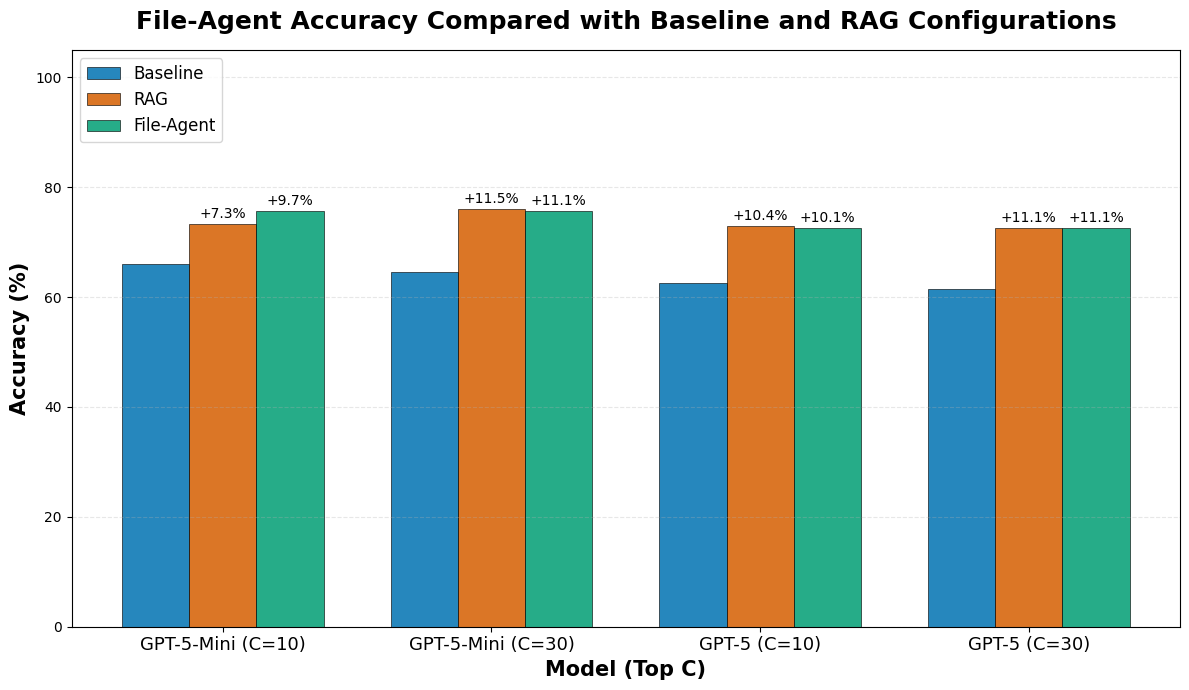

In [25]:
results = []

models = ['gpt_5_mini', 'gpt_5']
file_agent_models = ['gpt-5-mini', 'gpt-5']
configs_list = [10, 30]
model_labels = ['GPT-5-Mini', 'GPT-5']

for idx, model in enumerate(models):
    for c in configs_list:
        # Baseline
        baseline_data = df_baseline_fin[
            (df_baseline_fin['qna_model'] == model) &
            (df_baseline_fin['retrieval_model'] == model) &
            (df_baseline_fin['retrieval_count'] == c) &
            (df_baseline_fin['top_k'] == 1)
        ]
        baseline_acc = baseline_data['accuracy'].mean()
        
        # RAG
        rag_data = df_rag_fin[
            (df_rag_fin['qna_model'] == model) &
            (df_rag_fin['retrieval_model'] == model) &
            (df_rag_fin['retrieval_count'] == c) &
            (df_rag_fin['top_k'] == 1)
        ]
        rag_acc = rag_data['accuracy'].mean()
        
        # File-Agent
        file_agent_data = file_agent_fin[
            (file_agent_fin['model'] == file_agent_models[idx])
        ]
        file_agent_acc = file_agent_data['accuracy'].mean()
        
        results.append({
            'label': f'{model_labels[idx]} (C={c})',
            'Baseline': baseline_acc,
            'RAG': rag_acc,
            'File-Agent': file_agent_acc
        })

# DataFrame 생성
df = pd.DataFrame(results)

print(df)

# 이제 기존 figure 코드 그대로 실행
fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(len(df))
width = 0.25

colors = ['#0072B2', '#D55E00', '#009E73']  
baseline = ax.bar(x - width, df['Baseline'], width, 
                  label='Baseline', color=colors[0], alpha=0.85, edgecolor='black', linewidth=0.5)
internal = ax.bar(x, df['RAG'], width, 
                  label='RAG', color=colors[1], alpha=0.85, edgecolor='black', linewidth=0.5)
onedoc = ax.bar(x + width, df['File-Agent'], width, 
                label='File-Agent', color=colors[2], alpha=0.85, edgecolor='black', linewidth=0.5)

def add_value_labels(bars, baseline_values=None, show_diff=False):
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if show_diff and baseline_values is not None:
            diff = height - baseline_values[i]
            label_text = f'{diff:+.1f}%'
        else:
            label_text = f'{height:.1f}%'
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
               label_text, ha='center', va='bottom', fontsize=10)

add_value_labels(internal, baseline_values=df['Baseline'].values, show_diff=True)
add_value_labels(onedoc, baseline_values=df['Baseline'].values, show_diff=True)

ax.set_ylabel('Accuracy (%)', fontsize=15, fontweight='bold')
ax.set_xlabel('Model (Top C)', fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df['label'], fontsize=13)
ax.set_ylim(0, 105)
ax.legend(fontsize=12, loc='upper left')
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.title('File-Agent Accuracy Compared with Baseline and RAG Configurations', fontsize=18, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

               label   Baseline        RAG  File-Agent
0  GPT-5-Mini (C=10)  84.992560  84.144345   85.825893
1  GPT-5-Mini (C=30)  84.992560  85.669643   85.825893
2       GPT-5 (C=10)  80.825893  81.986607   79.791667
3       GPT-5 (C=30)  78.965774  81.986607   79.791667


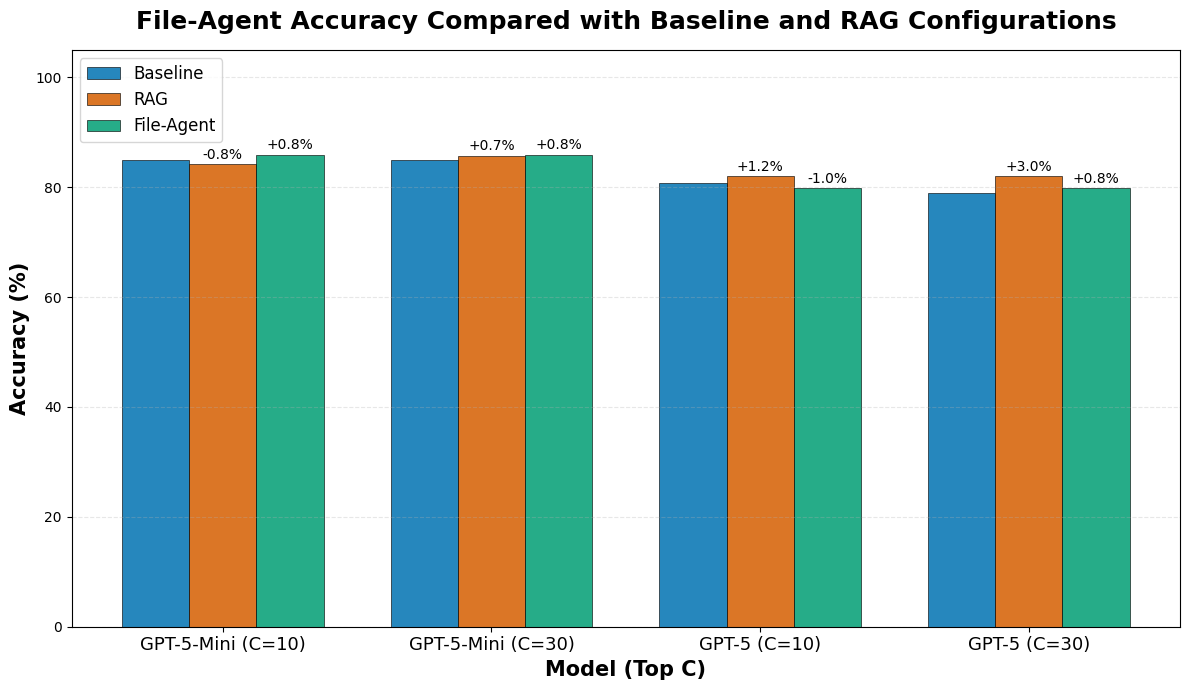

In [26]:
results = []

models = ['gpt_5_mini', 'gpt_5']
file_agent_models = ['gpt-5-mini', 'gpt-5']
configs_list = [10, 30]
model_labels = ['GPT-5-Mini', 'GPT-5']

for idx, model in enumerate(models):
    for c in configs_list:
        # Baseline
        baseline_data_adj = df_baseline_fin_adj[
            (df_baseline_fin_adj['qna_model'] == model) &
            (df_baseline_fin_adj['retrieval_model'] == model) &
            (df_baseline_fin_adj['retrieval_count'] == c) &
            (df_baseline_fin_adj['top_k'] == 1)
        ]
        baseline_acc_adj = baseline_data_adj['adjusted_accuracy'].mean()
        
        # RAG
        rag_data_adj = df_rag_fin_adj[
            (df_rag_fin_adj['qna_model'] == model) &
            (df_rag_fin_adj['retrieval_model'] == model) &
            (df_rag_fin_adj['retrieval_count'] == c) &
            (df_rag_fin_adj['top_k'] == 1)
        ]
        rag_acc_adj = rag_data_adj['adjusted_accuracy'].mean()
        
        # File-Agent
        file_agent_data_adj = file_agent_fin_adj[
            (file_agent_fin_adj['model'] == file_agent_models[idx])
        ]
        file_agent_acc_adj = file_agent_data_adj['adjusted_accuracy'].mean()
        
        results.append({
            'label': f'{model_labels[idx]} (C={c})',
            'Baseline': baseline_acc_adj,
            'RAG': rag_acc_adj,
            'File-Agent': file_agent_acc_adj
        })

# DataFrame 생성
df = pd.DataFrame(results)

print(df)

# 이제 기존 figure 코드 그대로 실행
fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(len(df))
width = 0.25

colors = ['#0072B2', '#D55E00', '#009E73']  
baseline = ax.bar(x - width, df['Baseline'], width, 
                  label='Baseline', color=colors[0], alpha=0.85, edgecolor='black', linewidth=0.5)
internal = ax.bar(x, df['RAG'], width, 
                  label='RAG', color=colors[1], alpha=0.85, edgecolor='black', linewidth=0.5)
onedoc = ax.bar(x + width, df['File-Agent'], width, 
                label='File-Agent', color=colors[2], alpha=0.85, edgecolor='black', linewidth=0.5)

def add_value_labels(bars, baseline_values=None, show_diff=False):
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if show_diff and baseline_values is not None:
            diff = height - baseline_values[i]
            label_text = f'{diff:+.1f}%'
        else:
            label_text = f'{height:.1f}%'
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
               label_text, ha='center', va='bottom', fontsize=10)

add_value_labels(internal, baseline_values=df['Baseline'].values, show_diff=True)
add_value_labels(onedoc, baseline_values=df['Baseline'].values, show_diff=True)

ax.set_ylabel('Accuracy (%)', fontsize=15, fontweight='bold')
ax.set_xlabel('Model (Top C)', fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df['label'], fontsize=13)
ax.set_ylim(0, 105)
ax.legend(fontsize=12, loc='upper left')
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.title('File-Agent Accuracy Compared with Baseline and RAG Configurations', fontsize=18, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

               label   Baseline        RAG  File-Agent
0  GPT-5-Mini (C=10)  88.898810  86.904762   89.389881
1  GPT-5-Mini (C=30)  87.470238  89.389881   89.389881
2       GPT-5 (C=10)  85.267857  83.883929   84.069940
3       GPT-5 (C=30)  82.247024  83.958333   84.069940


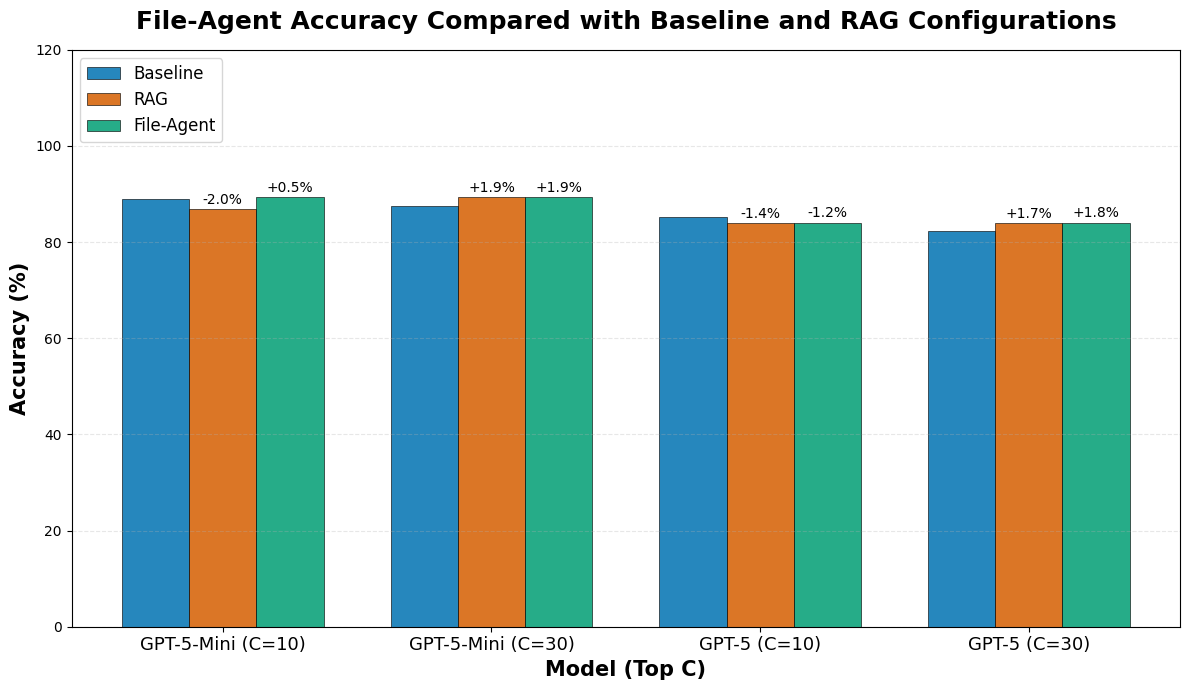

In [27]:
results = []

models = ['gpt_5_mini', 'gpt_5']
file_agent_models = ['gpt-5-mini', 'gpt-5']
configs_list = [10, 30]
model_labels = ['GPT-5-Mini', 'GPT-5']

for idx, model in enumerate(models):
    for c in configs_list:
        # Baseline
        baseline_data_both_adj = df_baseline_fin_both_adj[
            (df_baseline_fin_both_adj['qna_model'] == model) &
            (df_baseline_fin_both_adj['retrieval_model'] == model) &
            (df_baseline_fin_both_adj['retrieval_count'] == c) &
            (df_baseline_fin_both_adj['top_k'] == 1)
        ]
        baseline_acc_both_adj = baseline_data_both_adj['adjusted_accuracy'].mean()
        
        # RAG
        rag_data_both_adj = df_rag_fin_both_adj[
            (df_rag_fin_both_adj['qna_model'] == model) &
            (df_rag_fin_both_adj['retrieval_model'] == model) &
            (df_rag_fin_both_adj['retrieval_count'] == c) &
            (df_rag_fin_both_adj['top_k'] == 1)
        ]
        rag_acc_both_adj = rag_data_both_adj['adjusted_accuracy'].mean()
        
        # File-Agent
        file_agent_data_both_adj = file_agent_fin_both_adj[
            (file_agent_fin_both_adj['model'] == file_agent_models[idx])
        ]
        file_agent_acc_both_adj = file_agent_data_both_adj['adjusted_accuracy'].mean()
        
        results.append({
            'label': f'{model_labels[idx]} (C={c})',
            'Baseline': baseline_acc_both_adj,
            'RAG': rag_acc_both_adj,
            'File-Agent': file_agent_acc_both_adj
        })

# DataFrame 생성
df = pd.DataFrame(results)

print(df)

# 이제 기존 figure 코드 그대로 실행
fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(len(df))
width = 0.25

colors = ['#0072B2', '#D55E00', '#009E73']  
baseline = ax.bar(x - width, df['Baseline'], width, 
                  label='Baseline', color=colors[0], alpha=0.85, edgecolor='black', linewidth=0.5)
internal = ax.bar(x, df['RAG'], width, 
                  label='RAG', color=colors[1], alpha=0.85, edgecolor='black', linewidth=0.5)
onedoc = ax.bar(x + width, df['File-Agent'], width, 
                label='File-Agent', color=colors[2], alpha=0.85, edgecolor='black', linewidth=0.5)

def add_value_labels(bars, baseline_values=None, show_diff=False):
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if show_diff and baseline_values is not None:
            diff = height - baseline_values[i]
            label_text = f'{diff:+.1f}%'
        else:
            label_text = f'{height:.1f}%'
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
               label_text, ha='center', va='bottom', fontsize=10)

add_value_labels(internal, baseline_values=df['Baseline'].values, show_diff=True)
add_value_labels(onedoc, baseline_values=df['Baseline'].values, show_diff=True)

ax.set_ylabel('Accuracy (%)', fontsize=15, fontweight='bold')
ax.set_xlabel('Model (Top C)', fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df['label'], fontsize=13)
ax.set_ylim(0, 120)
ax.legend(fontsize=12, loc='upper left')
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.title('File-Agent Accuracy Compared with Baseline and RAG Configurations', fontsize=18, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

In [21]:
df_baseline_st_filtered = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_baseline_combined_results_with_accuracy.csv')
df_rag_filtered = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_rag_combined_results_with_accuracy.csv')
df_baseline_te_filtered = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/baseline_openai_header_combined_results_with_accuracy.csv')
df_openai_header = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/openai_header_data_with_accuracy.csv')

df_baseline_st_filtered = df_baseline_st_filtered[(df_baseline_st_filtered['qna_model'] == 'gpt_5_mini') & (df_baseline_st_filtered['retrieval_model'] == 'gpt_5_mini')]
df_rag_filtered = df_rag_filtered[(df_rag_filtered['qna_model'] == 'gpt_5_mini') & (df_rag_filtered['retrieval_model'] == 'gpt_5_mini')]
df_baseline_te_filtered = df_baseline_te_filtered[(df_baseline_te_filtered['qna_model'] == 'gpt_5_mini') & (df_baseline_te_filtered['retrieval_model'] == 'gpt_5_mini')]

df_baseline_st_filtered2 = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_baseline_combined_results_with_adjusted_accuracy.csv')
df_rag_filtered2 = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_rag_combined_results_with_adjusted_accuracy.csv')
df_baseline_te_filtered2 = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/baseline_openai_header_combined_results_with_adjusted_accuracy.csv')
df_openai_header2 = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/openai_header_data_with_adjusted_accuracy.csv')

df_baseline_st_filtered2 = df_baseline_st_filtered2[(df_baseline_st_filtered2['qna_model'] == 'gpt_5_mini') & (df_baseline_st_filtered2['retrieval_model'] == 'gpt_5_mini')]
df_rag_filtered2 = df_rag_filtered2[(df_rag_filtered2['qna_model'] == 'gpt_5_mini') & (df_rag_filtered2['retrieval_model'] == 'gpt_5_mini')]
df_baseline_te_filtered2 = df_baseline_te_filtered2[(df_baseline_te_filtered2['qna_model'] == 'gpt_5_mini') & (df_baseline_te_filtered2['retrieval_model'] == 'gpt_5_mini')]

df_baseline_st_filtered3 = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_baseline_combined_results_with_both_adjusted_accuracy.csv')
df_rag_filtered3 = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_rag_combined_results_with_both_adjusted_accuracy.csv')
df_baseline_te_filtered3 = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/baseline_openai_header_combined_results_with_both_adjusted_accuracy.csv')
df_openai_header3 = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/openai_header_data_with_both_adjusted_accuracy.csv')

df_baseline_st_filtered3 = df_baseline_st_filtered3[(df_baseline_st_filtered3['qna_model'] == 'gpt_5_mini') & (df_baseline_st_filtered3['retrieval_model'] == 'gpt_5_mini')]
df_rag_filtered3 = df_rag_filtered3[(df_rag_filtered3['qna_model'] == 'gpt_5_mini') & (df_rag_filtered3['retrieval_model'] == 'gpt_5_mini')]
df_baseline_te_filtered3 = df_baseline_te_filtered3[(df_baseline_te_filtered3['qna_model'] == 'gpt_5_mini') & (df_baseline_te_filtered3['retrieval_model'] == 'gpt_5_mini')]

In [29]:
configs = ['K=1, C=10', 'K=1, C=30', 'K=3, C=10', 'K=3, C=30']
config_params = [
    {'top_k': 1, 'retrieval_count': 10},
    {'top_k': 1, 'retrieval_count': 30},
    {'top_k': 3, 'retrieval_count': 10},
    {'top_k': 3, 'retrieval_count': 30}
]

# ========== SentenceTransformer ==========
st_baseline_matched = []
st_baseline_unmatched = []
st_baseline_overall = []
st_rag_matched = []
st_rag_unmatched = []
st_rag_overall = []

for params in config_params:
    # Baseline
    b = df_baseline_st_filtered[(df_baseline_st_filtered['top_k'] == params['top_k']) & (df_baseline_st_filtered['retrieval_count'] == params['retrieval_count'])]
    st_baseline_matched.append(b[b['match'] == 1]['accuracy'].mean())
    st_baseline_unmatched.append(b[b['match'] == 0]['accuracy'].mean())
    st_baseline_overall.append(b['accuracy'].mean())
    
    # RAG
    r = df_rag_filtered[(df_rag_filtered['top_k'] == params['top_k']) & (df_rag_filtered['retrieval_count'] == params['retrieval_count'])]
    st_rag_matched.append(r[r['match'] == 1]['accuracy'].mean())
    st_rag_unmatched.append(r[r['match'] == 0]['accuracy'].mean())
    st_rag_overall.append(r['accuracy'].mean())

# ========== TextEmbedding ==========
te_baseline_matched = []
te_baseline_unmatched = []
te_baseline_overall = []
te_rag_matched = []
te_rag_unmatched = []
te_rag_overall = []

for params in config_params:
    # Baseline
    b = df_baseline_te_filtered[(df_baseline_te_filtered['top_k'] == params['top_k']) & (df_baseline_te_filtered['retrieval_count'] == params['retrieval_count'])]
    te_baseline_matched.append(b[b['match'] == 1]['accuracy'].mean())
    te_baseline_unmatched.append(b[b['match'] == 0]['accuracy'].mean())
    te_baseline_overall.append(b['accuracy'].mean())
    
    # RAG
    r = df_openai_header[(df_openai_header['top_k'] == params['top_k']) & (df_openai_header['retrieval_count'] == params['retrieval_count'])]
    te_rag_matched.append(r[r['match'] == 1]['accuracy'].mean())
    te_rag_unmatched.append(r[r['match'] == 0]['accuracy'].mean())
    te_rag_overall.append(r['accuracy'].mean())

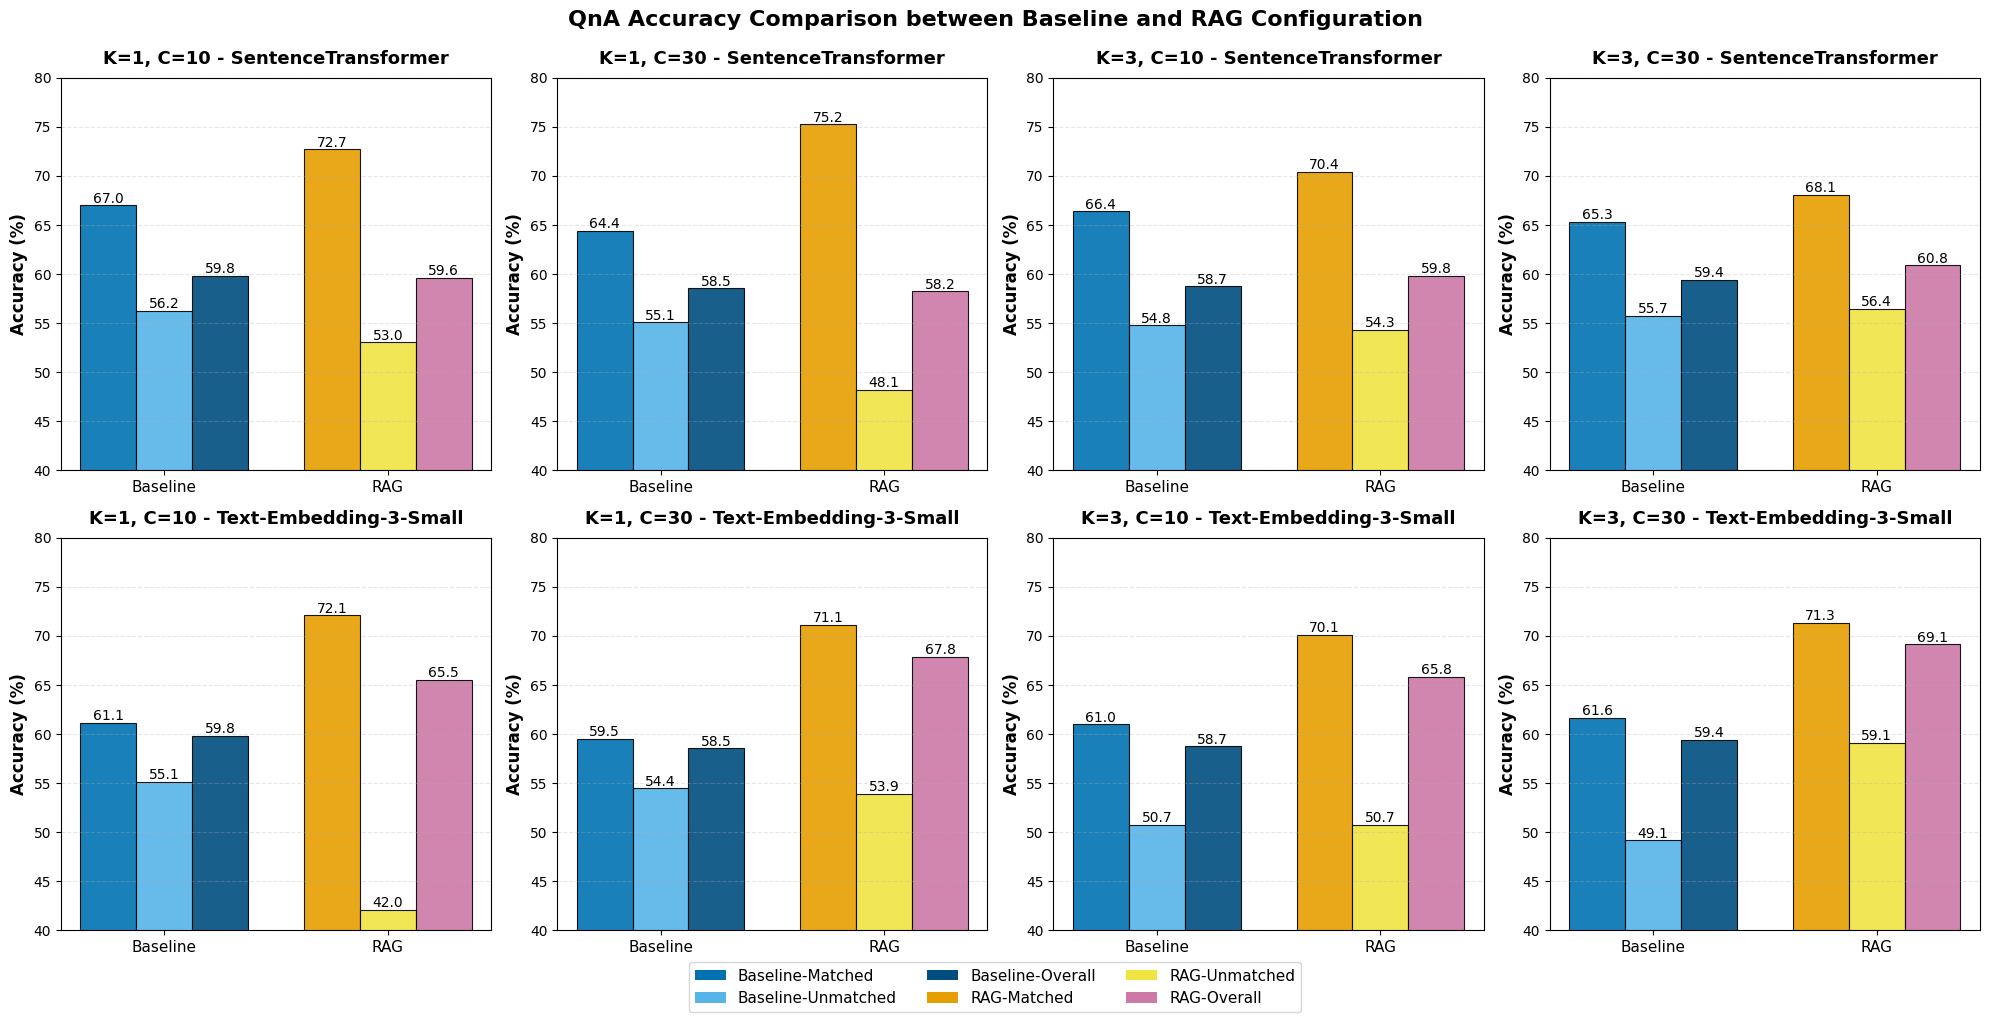

In [30]:
# Figure 생성 (4개 subplot - 각 configuration별)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Color blind friendly colors
colors_baseline = ['#0072B2', '#56B4E9', '#004D80']  # 파란색 계열
colors_internal = ['#E69F00', '#F0E442', '#CC79A7']  # 주황/노랑/보라 계열

for idx in range(8):
    ax = axes[idx]
    config_idx = idx % 4
    config = configs[config_idx]

    x = np.arange(2)
    width = 0.25
    
    if idx < 4:    # SentenceTransformer
        baseline_data = [st_baseline_matched[config_idx], st_baseline_unmatched[config_idx], st_baseline_overall[config_idx]]
        internal_data = [st_rag_matched[config_idx], st_rag_unmatched[config_idx], st_rag_overall[config_idx]]
        title = f'{config} - SentenceTransformer'
    else:  # Text-Embedding-3-Small
        baseline_data = [te_baseline_matched[config_idx], te_baseline_unmatched[config_idx], te_baseline_overall[config_idx]]
        internal_data = [te_rag_matched[config_idx], te_rag_unmatched[config_idx], te_rag_overall[config_idx]]
        title = f'{config} - Text-Embedding-3-Small'
    
    # Baseline bars (파란색 계열)
    for i, (value, color) in enumerate(zip(baseline_data, colors_baseline)):
        offset = (i - 1) * width
        bar = ax.bar(0 + offset, value, width, color=color, alpha=0.9, edgecolor='black', linewidth=0.8)
        ax.text(0 + offset, value, f'{value:.1f}', ha='center', va='bottom', fontsize=10)
    
    # Internal-QA bars (주황색 계열)
    for i, (value, color) in enumerate(zip(internal_data, colors_internal)):
        offset = (i - 1) * width
        bar = ax.bar(1 + offset, value, width, color=color, alpha=0.9, edgecolor='black', linewidth=0.8)
        ax.text(1 + offset, value, f'{value:.1f}', ha='center', va='bottom', fontsize=10)
    
    ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold', pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(['Baseline', 'RAG'], fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim(40, 80)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#0072B2', label='Baseline-Matched'),
    Patch(facecolor='#56B4E9', label='Baseline-Unmatched'),
    Patch(facecolor='#004D80', label='Baseline-Overall'),
    Patch(facecolor='#E69F00', label='RAG-Matched'),
    Patch(facecolor='#F0E442', label='RAG-Unmatched'),
    Patch(facecolor='#CC79A7', label='RAG-Overall')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=11, bbox_to_anchor=(0.5, -0.02))
plt.suptitle('QnA Accuracy Comparison between Baseline and RAG Configuration', 
             fontsize=16, fontweight='bold', y=0.99)
plt.tight_layout(rect=[0, 0.03, 1, 1])
#plt.savefig('/mnt/user-data/outputs/header_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [31]:
# ========== SentenceTransformer ==========
st_baseline_matched2 = []
st_baseline_unmatched2 = []
st_baseline_overall2 = []
st_rag_matched2 = []
st_rag_unmatched2 = []
st_rag_overall2 = []

for params in config_params:
    # Baseline
    b2 = df_baseline_st_filtered2[(df_baseline_st_filtered2['top_k'] == params['top_k']) & (df_baseline_st_filtered2['retrieval_count'] == params['retrieval_count'])]
    st_baseline_matched2.append(b2[b2['match'] == 1]['adjusted_accuracy'].mean())
    st_baseline_unmatched2.append(b2[b2['match'] == 0]['adjusted_accuracy'].mean())
    st_baseline_overall2.append(b2['adjusted_accuracy'].mean())
    
    # RAG
    r2 = df_rag_filtered2[(df_rag_filtered2['top_k'] == params['top_k']) & (df_rag_filtered2['retrieval_count'] == params['retrieval_count'])]
    st_rag_matched2.append(r2[r2['match'] == 1]['adjusted_accuracy'].mean())
    st_rag_unmatched2.append(r2[r2['match'] == 0]['adjusted_accuracy'].mean())
    st_rag_overall2.append(r2['adjusted_accuracy'].mean())

# ========== TextEmbedding ==========
te_baseline_matched2 = []
te_baseline_unmatched2 = []
te_baseline_overall2 = []
te_rag_matched2 = []
te_rag_unmatched2 = []
te_rag_overall2 = []

for params in config_params:
    # Baseline
    b2 = df_baseline_te_filtered2[(df_baseline_te_filtered2['top_k'] == params['top_k']) & (df_baseline_te_filtered2['retrieval_count'] == params['retrieval_count'])]
    te_baseline_matched2.append(b2[b2['match'] == 1]['adjusted_accuracy'].mean())
    te_baseline_unmatched2.append(b2[b2['match'] == 0]['adjusted_accuracy'].mean())
    te_baseline_overall2.append(b2['adjusted_accuracy'].mean())
    
    # RAG
    r2 = df_openai_header2[(df_openai_header2['top_k'] == params['top_k']) & (df_openai_header2['retrieval_count'] == params['retrieval_count'])]
    te_rag_matched2.append(r2[r2['match'] == 1]['adjusted_accuracy'].mean())
    te_rag_unmatched2.append(r2[r2['match'] == 0]['adjusted_accuracy'].mean())
    te_rag_overall2.append(r2['adjusted_accuracy'].mean())

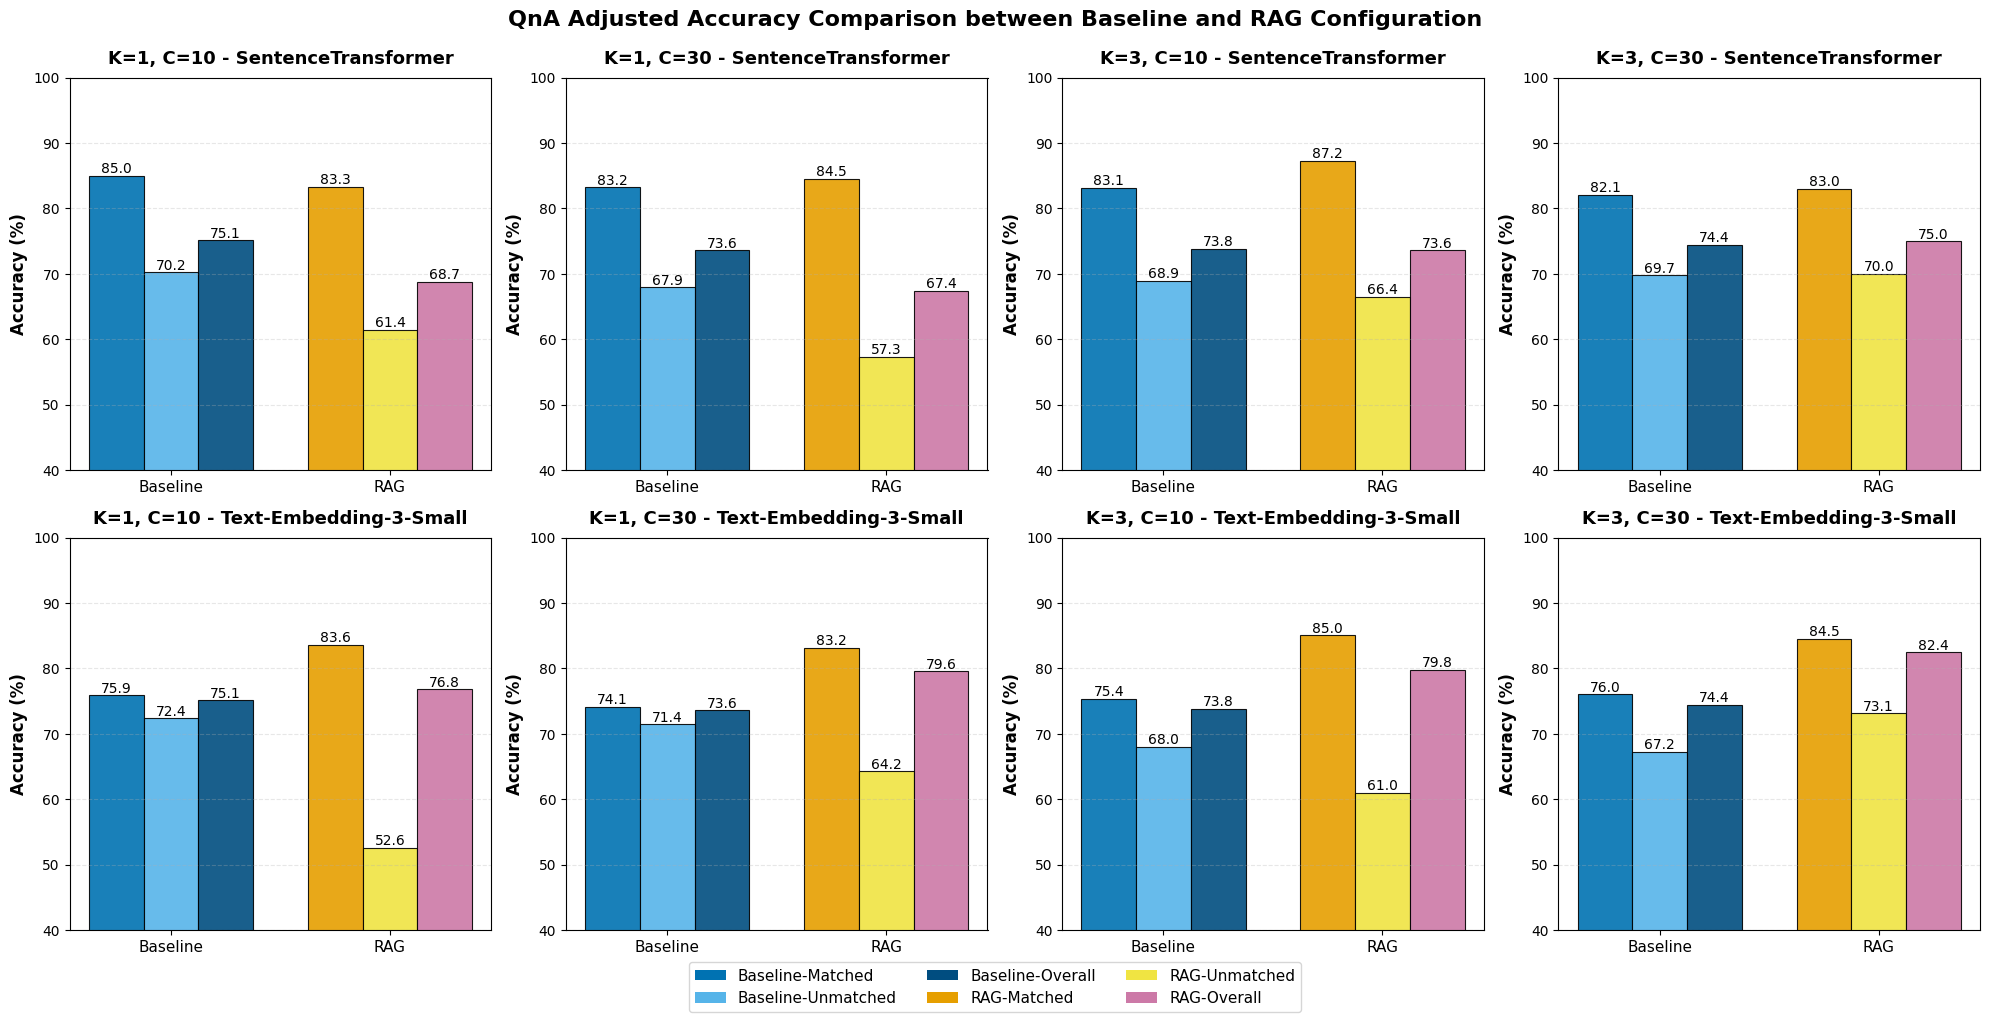

In [32]:
# Figure 생성 (4개 subplot - 각 configuration별)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Color blind friendly colors
colors_baseline = ['#0072B2', '#56B4E9', '#004D80']  # 파란색 계열
colors_internal = ['#E69F00', '#F0E442', '#CC79A7']  # 주황/노랑/보라 계열

for idx in range(8):
    ax = axes[idx]
    config_idx = idx % 4
    config = configs[config_idx]

    x = np.arange(2)
    width = 0.25
    
    if idx < 4:    # SentenceTransformer
        baseline_data = [st_baseline_matched2[config_idx], st_baseline_unmatched2[config_idx], st_baseline_overall2[config_idx]]
        internal_data = [st_rag_matched2[config_idx], st_rag_unmatched2[config_idx], st_rag_overall2[config_idx]]
        title = f'{config} - SentenceTransformer'
    else:  # Text-Embedding-3-Small
        baseline_data = [te_baseline_matched2[config_idx], te_baseline_unmatched2[config_idx], te_baseline_overall2[config_idx]]
        internal_data = [te_rag_matched2[config_idx], te_rag_unmatched2[config_idx], te_rag_overall2[config_idx]]
        title = f'{config} - Text-Embedding-3-Small'
    
    # Baseline bars (파란색 계열)
    for i, (value, color) in enumerate(zip(baseline_data, colors_baseline)):
        offset = (i - 1) * width
        bar = ax.bar(0 + offset, value, width, color=color, alpha=0.9, edgecolor='black', linewidth=0.8)
        ax.text(0 + offset, value, f'{value:.1f}', ha='center', va='bottom', fontsize=10)
    
    # Internal-QA bars (주황색 계열)
    for i, (value, color) in enumerate(zip(internal_data, colors_internal)):
        offset = (i - 1) * width
        bar = ax.bar(1 + offset, value, width, color=color, alpha=0.9, edgecolor='black', linewidth=0.8)
        ax.text(1 + offset, value, f'{value:.1f}', ha='center', va='bottom', fontsize=10)
    
    ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold', pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(['Baseline', 'RAG'], fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim(40, 100)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#0072B2', label='Baseline-Matched'),
    Patch(facecolor='#56B4E9', label='Baseline-Unmatched'),
    Patch(facecolor='#004D80', label='Baseline-Overall'),
    Patch(facecolor='#E69F00', label='RAG-Matched'),
    Patch(facecolor='#F0E442', label='RAG-Unmatched'),
    Patch(facecolor='#CC79A7', label='RAG-Overall')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=11, bbox_to_anchor=(0.5, -0.02))
plt.suptitle('QnA Adjusted Accuracy Comparison between Baseline and RAG Configuration', 
             fontsize=16, fontweight='bold', y=0.99)
plt.tight_layout(rect=[0, 0.03, 1, 1])
#plt.savefig('/mnt/user-data/outputs/header_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [33]:
# ========== SentenceTransformer ==========
st_baseline_matched3 = []
st_baseline_unmatched3 = []
st_baseline_overall3 = []
st_rag_matched3 = []
st_rag_unmatched3 = []
st_rag_overall3 = []

for params in config_params:
    # Baseline
    b3 = df_baseline_st_filtered3[(df_baseline_st_filtered3['top_k'] == params['top_k']) & (df_baseline_st_filtered3['retrieval_count'] == params['retrieval_count'])]
    st_baseline_matched3.append(b3[b3['match'] == 1]['adjusted_accuracy'].mean())
    st_baseline_unmatched3.append(b3[b3['match'] == 0]['adjusted_accuracy'].mean())
    st_baseline_overall3.append(b3['adjusted_accuracy'].mean())
    
    # RAG
    r3 = df_rag_filtered3[(df_rag_filtered3['top_k'] == params['top_k']) & (df_rag_filtered3['retrieval_count'] == params['retrieval_count'])]
    st_rag_matched3.append(r3[r3['match'] == 1]['adjusted_accuracy'].mean())
    st_rag_unmatched3.append(r3[r3['match'] == 0]['adjusted_accuracy'].mean())
    st_rag_overall3.append(r3['adjusted_accuracy'].mean())

# ========== TextEmbedding ==========
te_baseline_matched3 = []
te_baseline_unmatched3 = []
te_baseline_overall3 = []
te_rag_matched3 = []
te_rag_unmatched3 = []
te_rag_overall3 = []

for params in config_params:
    # Baseline
    b3 = df_baseline_te_filtered3[(df_baseline_te_filtered3['top_k'] == params['top_k']) & (df_baseline_te_filtered3['retrieval_count'] == params['retrieval_count'])]
    te_baseline_matched3.append(b3[b3['match'] == 1]['adjusted_accuracy'].mean())
    te_baseline_unmatched3.append(b3[b3['match'] == 0]['adjusted_accuracy'].mean())
    te_baseline_overall3.append(b3['adjusted_accuracy'].mean())
    
    # RAG
    r3 = df_openai_header3[(df_openai_header3['top_k'] == params['top_k']) & (df_openai_header3['retrieval_count'] == params['retrieval_count'])]
    te_rag_matched3.append(r3[r3['match'] == 1]['adjusted_accuracy'].mean())
    te_rag_unmatched3.append(r3[r3['match'] == 0]['adjusted_accuracy'].mean())
    te_rag_overall3.append(r3['adjusted_accuracy'].mean())

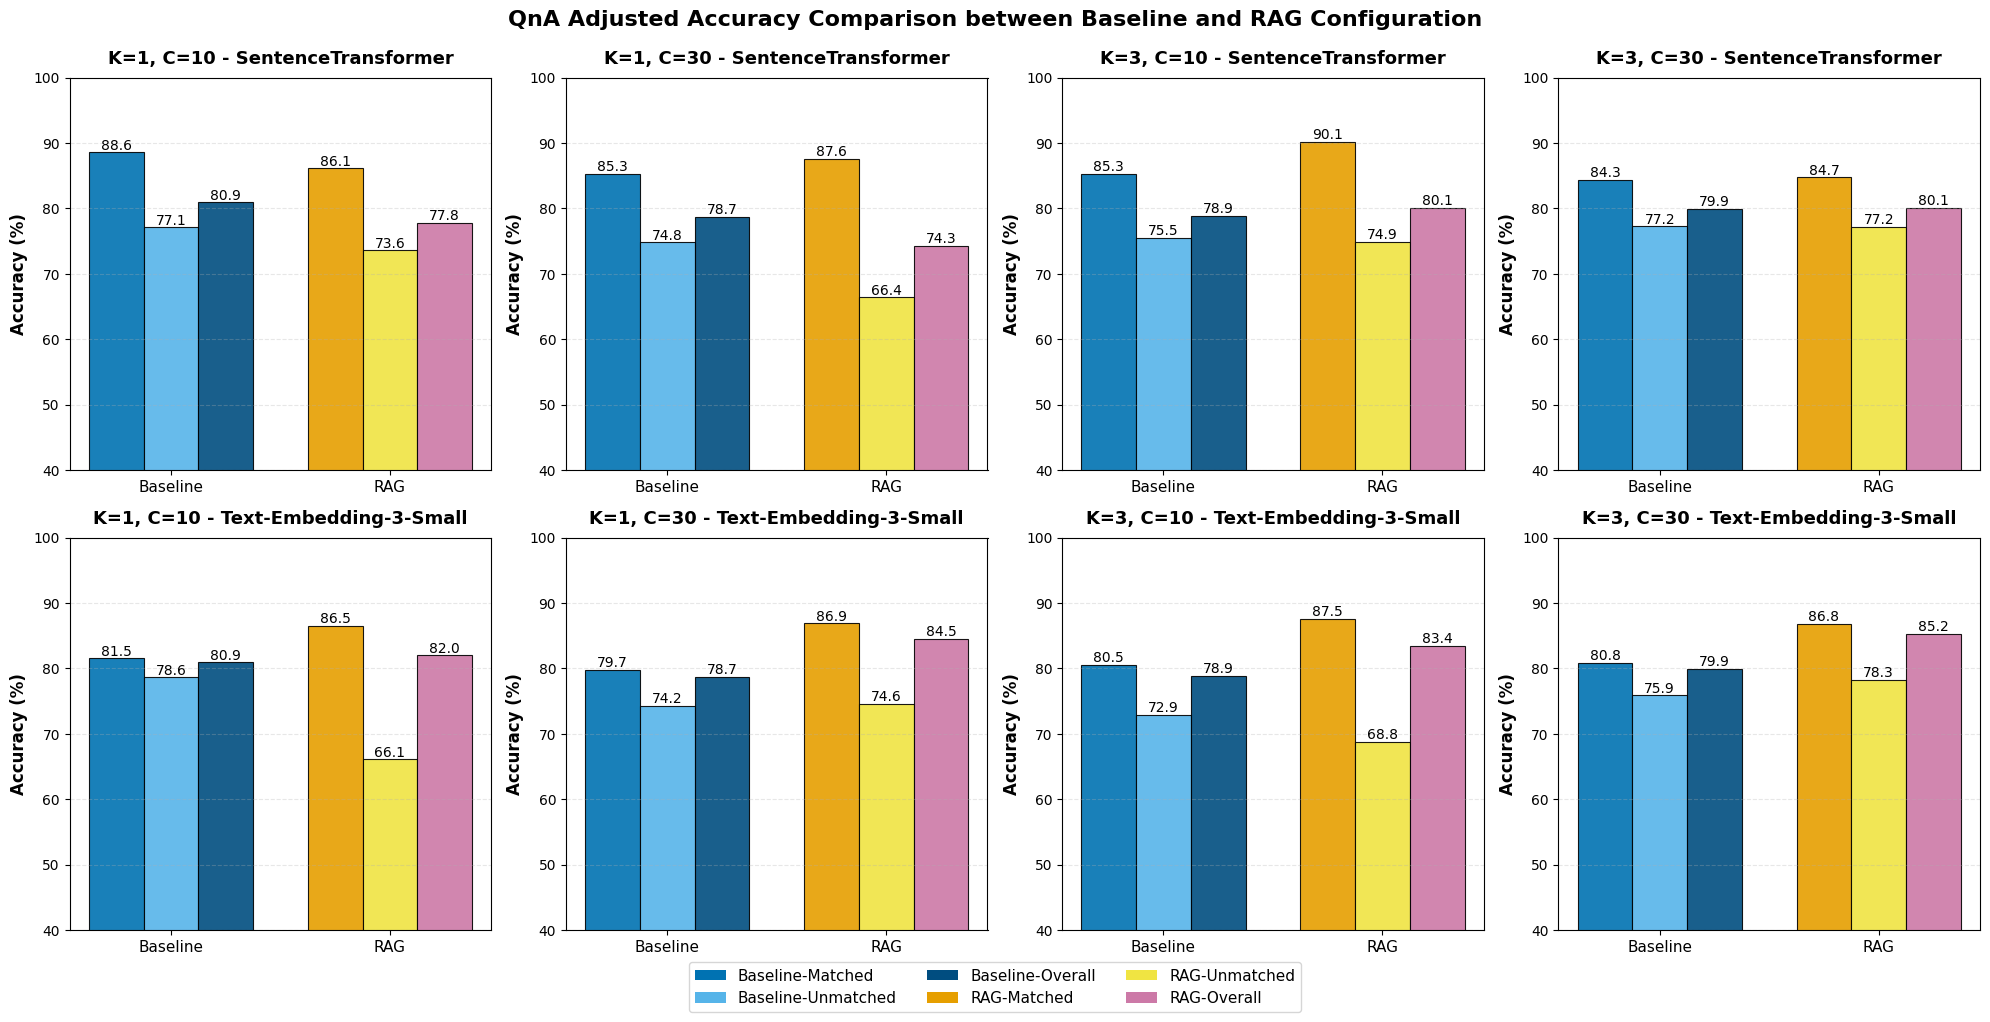

In [34]:
# Figure 생성 (4개 subplot - 각 configuration별)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Color blind friendly colors
colors_baseline = ['#0072B2', '#56B4E9', '#004D80']  # 파란색 계열
colors_internal = ['#E69F00', '#F0E442', '#CC79A7']  # 주황/노랑/보라 계열

for idx in range(8):
    ax = axes[idx]
    config_idx = idx % 4
    config = configs[config_idx]

    x = np.arange(2)
    width = 0.25
    
    if idx < 4:    # SentenceTransformer
        baseline_data = [st_baseline_matched3[config_idx], st_baseline_unmatched3[config_idx], st_baseline_overall3[config_idx]]
        internal_data = [st_rag_matched3[config_idx], st_rag_unmatched3[config_idx], st_rag_overall3[config_idx]]
        title = f'{config} - SentenceTransformer'
    else:  # Text-Embedding-3-Small
        baseline_data = [te_baseline_matched3[config_idx], te_baseline_unmatched3[config_idx], te_baseline_overall3[config_idx]]
        internal_data = [te_rag_matched3[config_idx], te_rag_unmatched3[config_idx], te_rag_overall3[config_idx]]
        title = f'{config} - Text-Embedding-3-Small'
    
    # Baseline bars (파란색 계열)
    for i, (value, color) in enumerate(zip(baseline_data, colors_baseline)):
        offset = (i - 1) * width
        bar = ax.bar(0 + offset, value, width, color=color, alpha=0.9, edgecolor='black', linewidth=0.8)
        ax.text(0 + offset, value, f'{value:.1f}', ha='center', va='bottom', fontsize=10)
    
    # Internal-QA bars (주황색 계열)
    for i, (value, color) in enumerate(zip(internal_data, colors_internal)):
        offset = (i - 1) * width
        bar = ax.bar(1 + offset, value, width, color=color, alpha=0.9, edgecolor='black', linewidth=0.8)
        ax.text(1 + offset, value, f'{value:.1f}', ha='center', va='bottom', fontsize=10)
    
    ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold', pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(['Baseline', 'RAG'], fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim(40, 100)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#0072B2', label='Baseline-Matched'),
    Patch(facecolor='#56B4E9', label='Baseline-Unmatched'),
    Patch(facecolor='#004D80', label='Baseline-Overall'),
    Patch(facecolor='#E69F00', label='RAG-Matched'),
    Patch(facecolor='#F0E442', label='RAG-Unmatched'),
    Patch(facecolor='#CC79A7', label='RAG-Overall')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=11, bbox_to_anchor=(0.5, -0.02))
plt.suptitle('QnA Adjusted Accuracy Comparison between Baseline and RAG Configuration', 
             fontsize=16, fontweight='bold', y=0.99)
plt.tight_layout(rect=[0, 0.03, 1, 1])
#plt.savefig('/mnt/user-data/outputs/header_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [35]:
def calculate_question_wise_accuracy_exclude(df, ground_truth_json_path):
    """Calculate accuracy for each question across all cases"""
    
    with open(ground_truth_json_path, "r") as f:
        gt_data = json.load(f)
    
    Questions = ["Q0", "Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]
    
    question_stats = {q: {'correct': 0, 'total': 0} for q in Questions}
    
    for _, row in df.iterrows():
        case_id = row["case_id"]
        gt_entry = gt_data.get(case_id)
        
        if not gt_entry:
            continue
        
        q0_value = str(gt_entry.get("Q0", "")).strip()
        skip_q1 = (q0_value == "BRCA1/2")
        
        for q in Questions:
            true = str(gt_entry.get(q, "")).strip()
            
            # Skip if ground truth is "Not Specified"
            if true == "Not Specified":
                continue
            if q == "Q1" and skip_q1:
                continue
            
            pred = str(row.get(q, "")).strip()
            
            # Count
            question_stats[q]['total'] += 1
            if pred == true and pred != "":
                question_stats[q]['correct'] += 1
    
    # Calculate accuracy for each question
    question_accuracies = {}
    for q in Questions:
        total = question_stats[q]['total']
        correct = question_stats[q]['correct']
        accuracy = (correct / total * 100) if total > 0 else 0
        question_accuracies[q] = accuracy
        print(f"{q}: {accuracy:.1f}% ({correct}/{total})")
    
    return question_accuracies

In [36]:
def calculate_question_wise_accuracy(df, ground_truth_json_path):
    """Calculate accuracy for each question across all cases (basic version - no exclusions)"""
    
    with open(ground_truth_json_path, "r") as f:
        gt_data = json.load(f)
    
    Questions = ["Q0", "Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]
    
    question_stats = {q: {'correct': 0, 'total': 0} for q in Questions}
    
    for _, row in df.iterrows():
        case_id = row["case_id"]
        gt_entry = gt_data.get(case_id)
        
        if not gt_entry:
            continue
        
        for q in Questions:
            pred = str(row.get(q, "")).strip()
            true = str(gt_entry.get(q, "")).strip()
            
            question_stats[q]['total'] += 1
            if pred == true and pred != "":
                question_stats[q]['correct'] += 1
    
    # Calculate accuracy 
    question_accuracies = {}
    for q in Questions:
        total = question_stats[q]['total']
        correct = question_stats[q]['correct']
        accuracy = (correct / total * 100) if total > 0 else 0
        question_accuracies[q] = accuracy
        print(f"{q}: {accuracy:.1f}% ({correct}/{total})")
    
    return question_accuracies

In [11]:
def calculate_question_wise_accuracy_both_exclude(df, ground_truth_json_path):
    """Calculate accuracy for each question across all cases"""
    
    with open(ground_truth_json_path, "r") as f:
        gt_data = json.load(f)
    
    Questions = ["Q0", "Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]
    
    question_stats = {q: {
        'correct': 0, 
        'total': 0, 
        'pairs': Counter(),
        'pred_dist': Counter(),
        'truth_dist': Counter()
    } for q in Questions}
    
    for _, row in df.iterrows():
        case_id = row["case_id"]
        gt_entry = gt_data.get(case_id)
        
        if not gt_entry:
            continue
        
        q0_value = str(gt_entry.get("Q0", "")).strip()
        skip_q1 = (q0_value == "BRCA1/2")
        
        for q in Questions:
            true = str(gt_entry.get(q, "")).strip()
            
            # Skip if ground truth is "Not Specified"
            if true == "Not Specified":
                continue
            if q == "Q1" and skip_q1:
                continue
            
            pred = str(row.get(q, "")).strip()

            if pred == "Not Specified":
                continue
            
            # Count
            question_stats[q]['total'] += 1
            if pred == true and pred != "":
                question_stats[q]['correct'] += 1

            question_stats[q]['pairs'][(true, pred)] += 1
            question_stats[q]['pred_dist'][pred] += 1
            question_stats[q]['truth_dist'][true] += 1
    
    # Calculate accuracy for each question
    question_accuracies = {}
    for q in Questions:
        total = question_stats[q]['total']
        correct = question_stats[q]['correct']
        accuracy = (correct / total * 100) if total > 0 else 0
        question_accuracies[q] = accuracy
        print(f"{q}: {accuracy:.1f}% ({correct}/{total})")

        if question_stats[q]['pred_dist']:
            pred_parts = [f"{val}: {cnt} ({cnt/total*100:.1f}%)" 
                         for val, cnt in question_stats[q]['pred_dist'].most_common()]
            print(f"  Pred - {', '.join(pred_parts)}")

        if question_stats[q]['truth_dist']:
            truth_parts = [f"{val}: {cnt} ({cnt/total*100:.1f}%)" 
                          for val, cnt in question_stats[q]['truth_dist'].most_common()]
            print(f"  Truth - {', '.join(truth_parts)}")

        if question_stats[q]['pairs']:
            print("  Details:")
            for (pred, true), count in question_stats[q]['pairs'].most_common():
                pct = count / total * 100
                match_mark = "✓" if pred == true else "✗"
                print(f"    {match_mark} {pred} -> {true}: {count} ({pct:.1f}%)")
    
    return question_accuracies

In [38]:
ground_truth_json_path = "/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/dataset/new_ground_truth.json"


print("Baseline Matched:")
baseline_matched_acc = calculate_question_wise_accuracy(
    df_baseline_acc[df_baseline_acc['match'] == 1],
    ground_truth_json_path
)

print("\nBaseline Unmatched:")
baseline_unmatched_acc = calculate_question_wise_accuracy(
    df_baseline_acc[df_baseline_acc['match'] == 0],
    ground_truth_json_path
)

print("\nRAG Matched:")
rag_matched_acc = calculate_question_wise_accuracy(
    df_rag_acc[df_rag_acc['match'] == 1],
    ground_truth_json_path
)

print("\nRAG Unmatched:")
rag_unmatched_acc = calculate_question_wise_accuracy(
    df_rag_acc[df_rag_acc['match'] == 0],
    ground_truth_json_path
)

print("\nFile-Agent:")
file_agent_acc = calculate_question_wise_accuracy(
    file_agent,
    ground_truth_json_path
)

Baseline Matched:
Q0: 100.0% (599/599)
Q1: 69.1% (414/599)
Q2: 62.3% (373/599)
Q3: 71.6% (429/599)
Q4: 32.7% (196/599)
Q5: 70.6% (423/599)
Q6: 84.0% (503/599)
Q7: 17.2% (103/599)
Q8: 71.8% (430/599)

Baseline Unmatched:
Q0: 100.0% (1081/1081)
Q1: 32.8% (355/1081)
Q2: 44.1% (477/1081)
Q3: 78.0% (843/1081)
Q4: 18.6% (201/1081)
Q5: 70.6% (763/1081)
Q6: 12.9% (139/1081)
Q7: 86.6% (936/1081)
Q8: 54.5% (589/1081)

RAG Matched:
Q0: 99.8% (598/599)
Q1: 82.6% (495/599)
Q2: 80.3% (481/599)
Q3: 60.9% (365/599)
Q4: 52.9% (317/599)
Q5: 83.8% (502/599)
Q6: 87.1% (522/599)
Q7: 30.6% (183/599)
Q8: 69.3% (415/599)

RAG Unmatched:
Q0: 99.9% (1080/1081)
Q1: 24.7% (267/1081)
Q2: 45.3% (490/1081)
Q3: 59.4% (642/1081)
Q4: 39.7% (429/1081)
Q5: 56.9% (615/1081)
Q6: 16.7% (180/1081)
Q7: 82.4% (891/1081)
Q8: 56.1% (606/1081)

File-Agent:
Q0: 100.0% (210/210)
Q1: 71.4% (150/210)
Q2: 89.5% (188/210)
Q3: 60.5% (127/210)
Q4: 55.2% (116/210)
Q5: 75.2% (158/210)
Q6: 48.1% (101/210)
Q7: 74.8% (157/210)
Q8: 67.6% (142/

In [39]:
print("Baseline ADJ Matched:")
baseline_matched_adj_acc = calculate_question_wise_accuracy_exclude(
    df_baseline_adj_acc[df_baseline_adj_acc['match'] == 1],
    ground_truth_json_path
)

print("\nBaseline ADJ Unmatched:")
baseline_unmatched_adj_acc = calculate_question_wise_accuracy_exclude(
    df_baseline_adj_acc[df_baseline_adj_acc['match'] == 0],
    ground_truth_json_path
)

print("\nRAG ADJ Matched:")
rag_matched_adj_acc = calculate_question_wise_accuracy_exclude(
    df_rag_adj_acc[df_rag_adj_acc['match'] == 1],
    ground_truth_json_path
)

print("\nRAG ADJ Unmatched:")
rag_unmatched_adj_acc = calculate_question_wise_accuracy_exclude(
    df_rag_adj_acc[df_rag_adj_acc['match'] == 0],
    ground_truth_json_path
)

print("\nFile-Agent ADJ:")
file_agent_adj_acc = calculate_question_wise_accuracy_exclude(
    file_agent_adj,
    ground_truth_json_path
)

Baseline ADJ Matched:
Q0: 100.0% (599/599)
Q1: 73.0% (238/326)
Q2: 0.0% (0/0)
Q3: 75.5% (428/567)
Q4: 43.3% (140/323)
Q5: 82.1% (412/502)
Q6: 100.0% (502/502)
Q7: 74.0% (54/73)
Q8: 71.8% (430/599)

Baseline ADJ Unmatched:
Q0: 100.0% (1081/1081)
Q1: 54.9% (146/266)
Q2: 37.4% (287/768)
Q3: 80.3% (842/1049)
Q4: 19.6% (178/909)
Q5: 79.6% (747/938)
Q6: 100.0% (106/106)
Q7: 90.7% (935/1031)
Q8: 54.5% (589/1081)

RAG ADJ Matched:
Q0: 99.8% (598/599)
Q1: 87.7% (286/326)
Q2: 0.0% (0/0)
Q3: 64.4% (365/567)
Q4: 62.8% (203/323)
Q5: 86.1% (432/502)
Q6: 99.4% (499/502)
Q7: 100.0% (73/73)
Q8: 69.3% (415/599)

RAG ADJ Unmatched:
Q0: 99.9% (1080/1081)
Q1: 40.6% (108/266)
Q2: 28.8% (221/768)
Q3: 61.2% (642/1049)
Q4: 39.5% (359/909)
Q5: 59.4% (557/938)
Q6: 82.1% (87/106)
Q7: 85.1% (877/1031)
Q8: 56.1% (606/1081)

File-Agent ADJ:
Q0: 100.0% (210/210)
Q1: 79.7% (59/74)
Q2: 88.5% (85/96)
Q3: 62.9% (127/202)
Q4: 56.5% (87/154)
Q5: 77.8% (140/180)
Q6: 96.1% (73/76)
Q7: 100.0% (138/138)
Q8: 67.6% (142/210)


In [19]:
ground_truth_json_path = "/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/dataset/new_ground_truth.json"

print("Baseline_ST Final ADJ Matched:")
baseline_matched_both_adj_acc = calculate_question_wise_accuracy_both_exclude(
    df_baseline_both_adj_acc[df_baseline_both_adj_acc['match'] == 1],
    ground_truth_json_path
)

print("\nBaseline_ST Final ADJ Unmatched:")
baseline_unmatched_both_adj_acc = calculate_question_wise_accuracy_both_exclude(
    df_baseline_both_adj_acc[df_baseline_both_adj_acc['match'] == 0],
    ground_truth_json_path
)

print("\nRAG_ST Final ADJ Matched:")
rag_matched_both_adj_acc = calculate_question_wise_accuracy_both_exclude(
    df_rag_both_adj_acc[df_rag_both_adj_acc['match'] == 1],
    ground_truth_json_path
)

print("\nRAG_ST Final ADJ Unmatched:")
rag_unmatched_both_adj_acc = calculate_question_wise_accuracy_both_exclude(
    df_rag_both_adj_acc[df_rag_both_adj_acc['match'] == 0],
    ground_truth_json_path
)


Baseline_ST Final ADJ Matched:
Q0: 100.0% (599/599)
  Pred - WES: 235 (39.2%), BRCA1/2: 212 (35.4%), WGS: 88 (14.7%), CMA: 64 (10.7%)
  Truth - WES: 235 (39.2%), BRCA1/2: 212 (35.4%), WGS: 88 (14.7%), CMA: 64 (10.7%)
  Details:
    ✓ WES -> WES: 235 (39.2%)
    ✓ BRCA1/2 -> BRCA1/2: 212 (35.4%)
    ✓ WGS -> WGS: 88 (14.7%)
    ✓ CMA -> CMA: 64 (10.7%)
Q1: 100.0% (238/238)
  Pred - Yes: 233 (97.9%), No: 5 (2.1%)
  Truth - Yes: 233 (97.9%), No: 5 (2.1%)
  Details:
    ✓ Yes -> Yes: 233 (97.9%)
    ✓ No -> No: 5 (2.1%)
Q2: 0.0% (0/0)
Q3: 77.1% (428/555)
  Pred - Yes: 389 (70.1%), No: 166 (29.9%)
  Truth - Yes: 362 (65.2%), No: 193 (34.8%)
  Details:
    ✓ Yes -> Yes: 312 (56.2%)
    ✓ No -> No: 116 (20.9%)
    ✗ No -> Yes: 77 (13.9%)
    ✗ Yes -> No: 50 (9.0%)
Q4: 47.3% (140/296)
  Pred - No: 192 (64.9%), Yes: 104 (35.1%)
  Truth - Yes: 260 (87.8%), No: 36 (12.2%)
  Details:
    ✗ Yes -> No: 156 (52.7%)
    ✓ Yes -> Yes: 104 (35.1%)
    ✓ No -> No: 36 (12.2%)
Q5: 83.6% (412/493)
  Pred - 

In [22]:
print("Baseline_TE Final ADJ Matched:")
baseline_te_matched_both_adj_acc = calculate_question_wise_accuracy_both_exclude(
    df_baseline_te_filtered3[df_baseline_te_filtered3['match'] == 1],
    ground_truth_json_path
)

print("\nBaseline_TE Final ADJ Unmatched:")
baseline_te_unmatched_both_adj_acc = calculate_question_wise_accuracy_both_exclude(
    df_baseline_te_filtered3[df_baseline_te_filtered3['match'] == 0],
    ground_truth_json_path
)

print("\nRAG_TE Final ADJ Matched:")
rag_te_matched_both_adj_acc = calculate_question_wise_accuracy_both_exclude(
    df_openai_header3[df_openai_header3['match'] == 1],
    ground_truth_json_path
)

print("\nRAG_TE Final ADJ Unmatched:")
rag_te_unmatched_both_adj_acc = calculate_question_wise_accuracy_both_exclude(
    df_openai_header3[df_openai_header3['match'] == 0],
    ground_truth_json_path
)


Baseline_TE Final ADJ Matched:
Q0: 100.0% (335/335)
  Pred - WES: 162 (48.4%), WGS: 98 (29.3%), BRCA1/2: 60 (17.9%), CMA: 15 (4.5%)
  Truth - WES: 162 (48.4%), WGS: 98 (29.3%), BRCA1/2: 60 (17.9%), CMA: 15 (4.5%)
  Details:
    ✓ WES -> WES: 162 (48.4%)
    ✓ WGS -> WGS: 98 (29.3%)
    ✓ BRCA1/2 -> BRCA1/2: 60 (17.9%)
    ✓ CMA -> CMA: 15 (4.5%)
Q1: 100.0% (80/80)
  Pred - Yes: 79 (98.8%), No: 1 (1.2%)
  Truth - Yes: 79 (98.8%), No: 1 (1.2%)
  Details:
    ✓ Yes -> Yes: 79 (98.8%)
    ✓ No -> No: 1 (1.2%)
Q2: 94.7% (89/94)
  Pred - Yes: 94 (100.0%)
  Truth - Yes: 89 (94.7%), No: 5 (5.3%)
  Details:
    ✓ Yes -> Yes: 89 (94.7%)
    ✗ No -> Yes: 5 (5.3%)
Q3: 85.7% (275/321)
  Pred - Yes: 276 (86.0%), No: 45 (14.0%)
  Truth - Yes: 262 (81.6%), No: 59 (18.4%)
  Details:
    ✓ Yes -> Yes: 246 (76.6%)
    ✗ No -> Yes: 30 (9.3%)
    ✓ No -> No: 29 (9.0%)
    ✗ Yes -> No: 16 (5.0%)
Q4: 30.6% (71/232)
  Pred - No: 168 (72.4%), Yes: 64 (27.6%)
  Truth - Yes: 225 (97.0%), No: 7 (3.0%)
  Details:


In [23]:
question_labels = ['Q0: Test', 'Q1: Age', 'Q2: Provider', 'Q3: Medical-Necessity', 
                   'Q4: Pre-Tests', 'Q5: Family-History', 'Q6: Genetic-Counseling', 
                   'Q7: CPT-Code', 'Q8: Decision']

Questions = ["Q0", "Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]

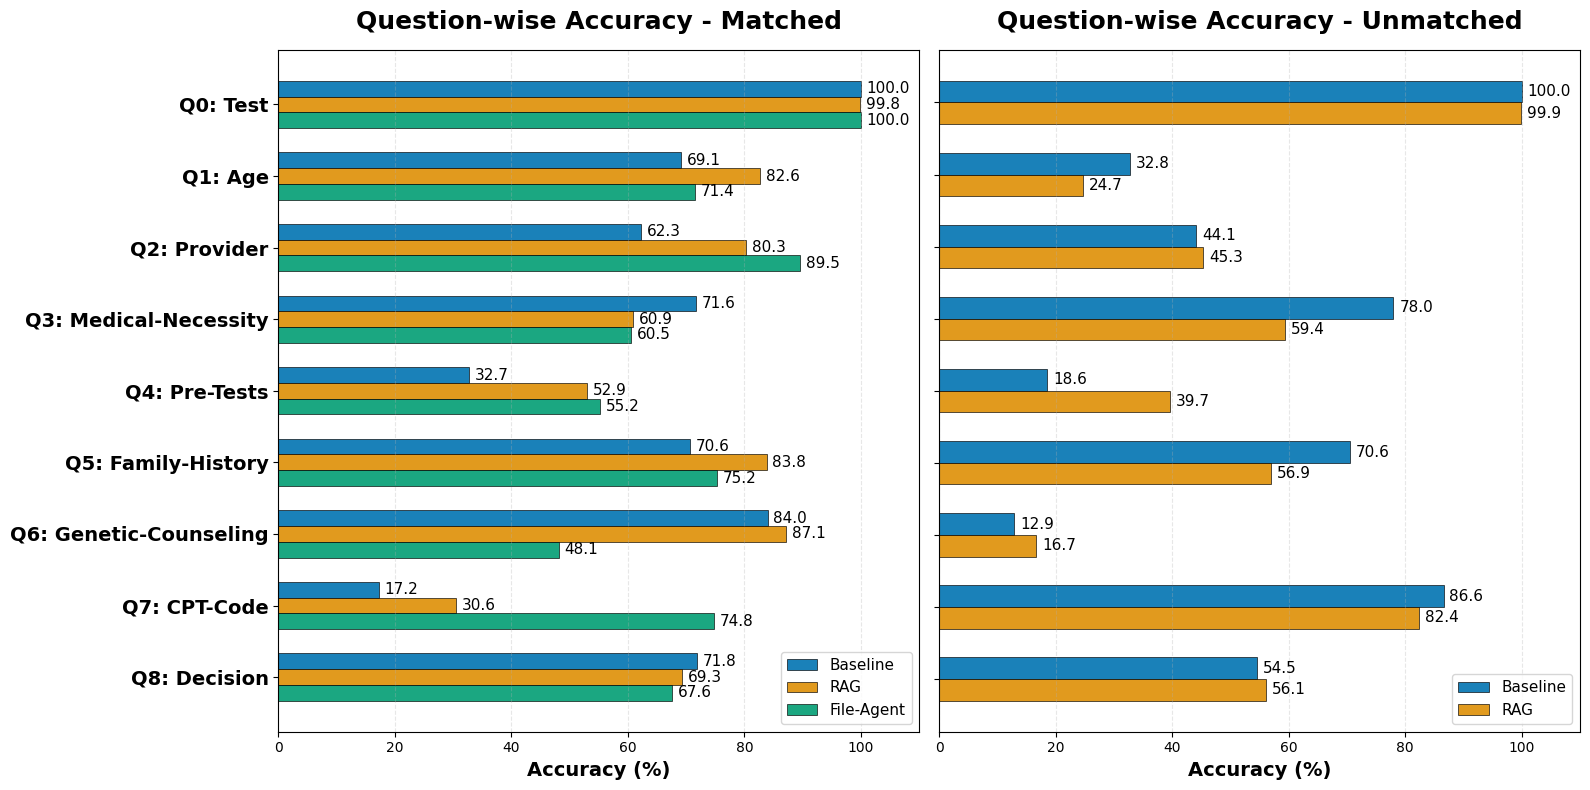

In [43]:
# Matched 데이터 (adjusted 버전 사용)
baseline_matched = [baseline_matched_acc[q] for q in Questions]
rag_matched = [rag_matched_acc[q] for q in Questions]
file_agent_matched = [file_agent_acc[q] for q in Questions]

# Unmatched 데이터 (adjusted 버전 사용)
baseline_unmatched_data = [baseline_unmatched_acc[q] for q in Questions]
rag_unmatched_data = [rag_unmatched_acc[q] for q in Questions]

# Figure 생성
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# 왼쪽: Matched
y = np.arange(len(question_labels))
height = 0.22

bars1 = ax1.barh(y - height, baseline_matched, height, label='Baseline', 
                 color='#0173B2', alpha=0.9, edgecolor='black', linewidth=0.5)
bars2 = ax1.barh(y, rag_matched, height, label='RAG', 
                 color='#DE8F05', alpha=0.9, edgecolor='black', linewidth=0.5)
bars3 = ax1.barh(y + height, file_agent_matched, height, label='File-Agent', 
                 color='#029E73', alpha=0.9, edgecolor='black', linewidth=0.5)

# 값 표시
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        width = bar.get_width()
        ax1.text(width + 1, bar.get_y() + bar.get_height()/2.,
                f'{width:.1f}', ha='left', va='center', fontsize=11)

ax1.set_xlabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax1.set_title('Question-wise Accuracy - Matched', fontsize=18, fontweight='bold', pad=15)
ax1.set_yticks(y)
ax1.set_yticklabels(question_labels, fontsize=14, fontweight='bold')
ax1.legend(fontsize=11, loc='lower right')
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.set_xlim(0, 110)
ax1.invert_yaxis()

# 오른쪽: Unmatched
height_unmatched = 0.3

bars4 = ax2.barh(y - height_unmatched/2, baseline_unmatched_data, height_unmatched, 
                 label='Baseline', color='#0173B2', alpha=0.9, 
                 edgecolor='black', linewidth=0.5)
bars5 = ax2.barh(y + height_unmatched/2, rag_unmatched_data, height_unmatched, 
                 label='RAG', color='#DE8F05', alpha=0.9, 
                 edgecolor='black', linewidth=0.5)

# 값 표시
for bars in [bars4, bars5]:
    for bar in bars:
        width = bar.get_width()
        ax2.text(width + 1, bar.get_y() + bar.get_height()/2.,
                f'{width:.1f}', ha='left', va='center', fontsize=11)

ax2.set_xlabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax2.set_title('Question-wise Accuracy - Unmatched', fontsize=18, fontweight='bold', pad=15)
ax2.set_yticks(y)
ax2.set_yticklabels([])
ax2.legend(fontsize=11, loc='lower right')
ax2.grid(axis='x', alpha=0.3, linestyle='--')
ax2.set_xlim(0, 110)
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

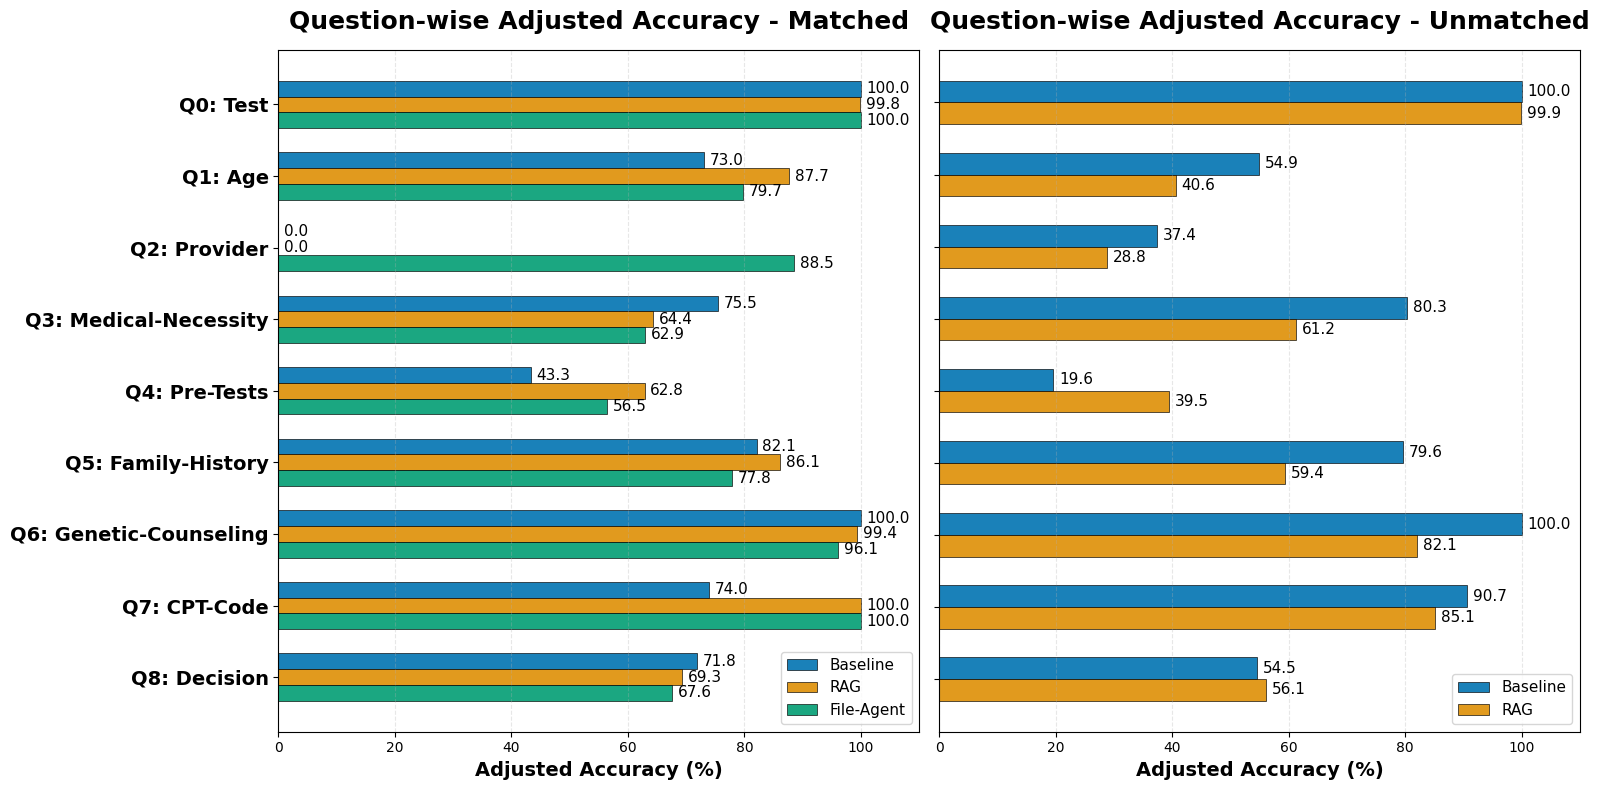

In [44]:
# Matched 데이터 (adjusted 버전 사용)
baseline_matched = [baseline_matched_adj_acc[q] for q in Questions]
rag_matched = [rag_matched_adj_acc[q] for q in Questions]
file_agent_matched = [file_agent_adj_acc[q] for q in Questions]

# Unmatched 데이터 (adjusted 버전 사용)
baseline_unmatched_data = [baseline_unmatched_adj_acc[q] for q in Questions]
rag_unmatched_data = [rag_unmatched_adj_acc[q] for q in Questions]

# Figure 생성
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# 왼쪽: Matched
y = np.arange(len(question_labels))
height = 0.22

bars1 = ax1.barh(y - height, baseline_matched, height, label='Baseline', 
                 color='#0173B2', alpha=0.9, edgecolor='black', linewidth=0.5)
bars2 = ax1.barh(y, rag_matched, height, label='RAG', 
                 color='#DE8F05', alpha=0.9, edgecolor='black', linewidth=0.5)
bars3 = ax1.barh(y + height, file_agent_matched, height, label='File-Agent', 
                 color='#029E73', alpha=0.9, edgecolor='black', linewidth=0.5)

# 값 표시
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        width = bar.get_width()
        ax1.text(width + 1, bar.get_y() + bar.get_height()/2.,
                f'{width:.1f}', ha='left', va='center', fontsize=11)

ax1.set_xlabel('Adjusted Accuracy (%)', fontsize=14, fontweight='bold')
ax1.set_title('Question-wise Adjusted Accuracy - Matched', fontsize=18, fontweight='bold', pad=15)
ax1.set_yticks(y)
ax1.set_yticklabels(question_labels, fontsize=14, fontweight='bold')
ax1.legend(fontsize=11, loc='lower right')
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.set_xlim(0, 110)
ax1.invert_yaxis()

# 오른쪽: Unmatched
height_unmatched = 0.3

bars4 = ax2.barh(y - height_unmatched/2, baseline_unmatched_data, height_unmatched, 
                 label='Baseline', color='#0173B2', alpha=0.9, 
                 edgecolor='black', linewidth=0.5)
bars5 = ax2.barh(y + height_unmatched/2, rag_unmatched_data, height_unmatched, 
                 label='RAG', color='#DE8F05', alpha=0.9, 
                 edgecolor='black', linewidth=0.5)

# 값 표시
for bars in [bars4, bars5]:
    for bar in bars:
        width = bar.get_width()
        ax2.text(width + 1, bar.get_y() + bar.get_height()/2.,
                f'{width:.1f}', ha='left', va='center', fontsize=11)

ax2.set_xlabel('Adjusted Accuracy (%)', fontsize=14, fontweight='bold')
ax2.set_title('Question-wise Adjusted Accuracy - Unmatched', fontsize=18, fontweight='bold', pad=15)
ax2.set_yticks(y)
ax2.set_yticklabels([])
ax2.legend(fontsize=11, loc='lower right')
ax2.grid(axis='x', alpha=0.3, linestyle='--')
ax2.set_xlim(0, 110)
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

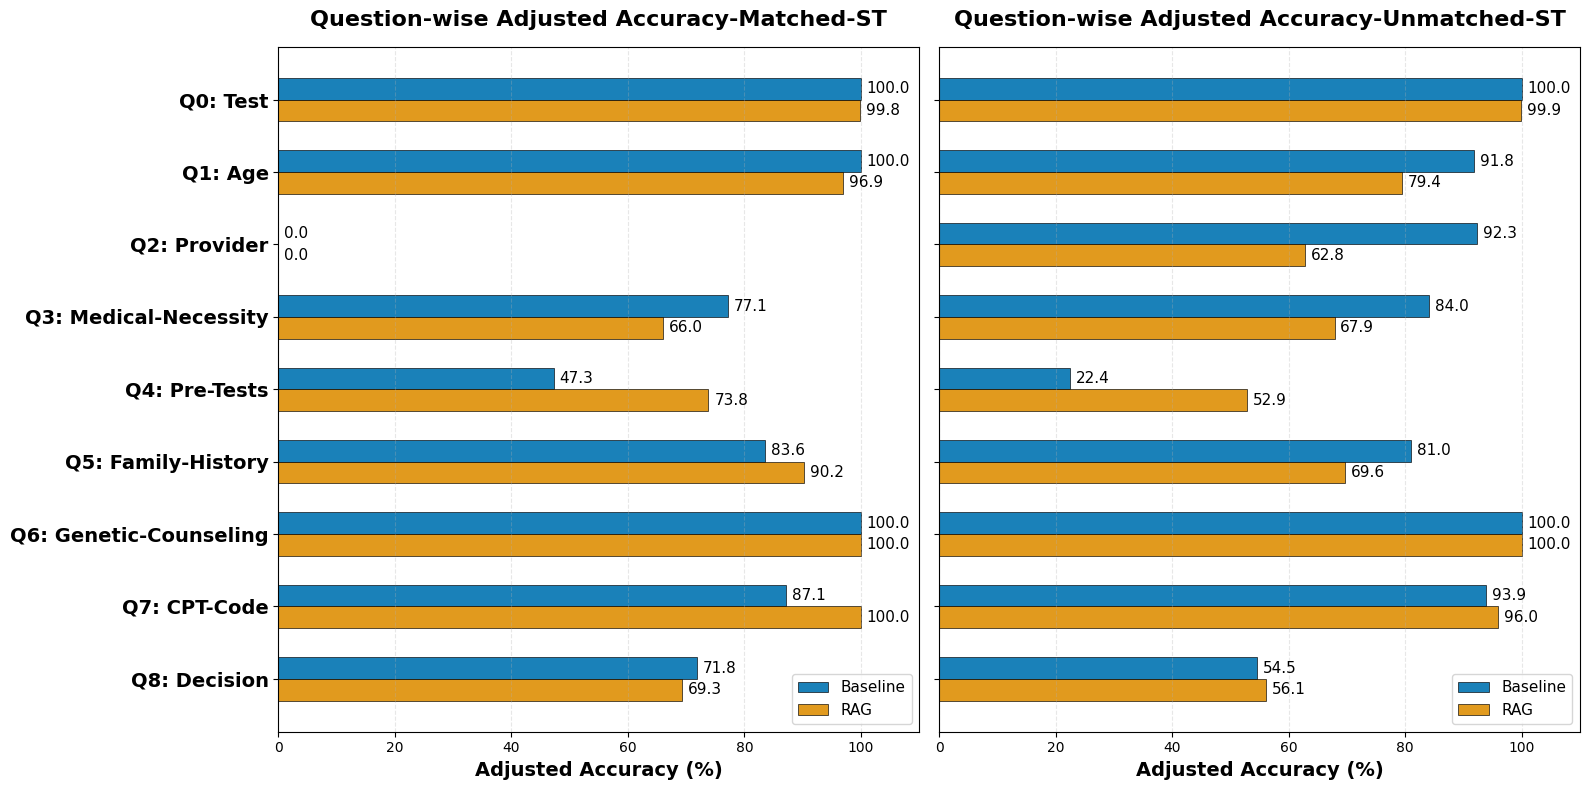

In [45]:
# Matched 데이터 (adjusted 버전 사용)
baseline_matched = [baseline_matched_both_adj_acc[q] for q in Questions]
rag_matched = [rag_matched_both_adj_acc[q] for q in Questions]
# Unmatched 데이터 (adjusted 버전 사용)
baseline_unmatched_data = [baseline_unmatched_both_adj_acc[q] for q in Questions]
rag_unmatched_data = [rag_unmatched_both_adj_acc[q] for q in Questions]

# Figure 생성
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# 왼쪽: Matched
y = np.arange(len(question_labels))
height = 0.3

bars1 = ax1.barh(y - height/2, baseline_matched, height, label='Baseline', 
                 color='#0173B2', alpha=0.9, edgecolor='black', linewidth=0.5)
bars2 = ax1.barh(y + height/2, rag_matched, height, label='RAG', 
                 color='#DE8F05', alpha=0.9, edgecolor='black', linewidth=0.5)

# 값 표시
for bars in [bars1, bars2]:
    for bar in bars:
        width = bar.get_width()
        ax1.text(width + 1, bar.get_y() + bar.get_height()/2.,
                f'{width:.1f}', ha='left', va='center', fontsize=11)

ax1.set_xlabel('Adjusted Accuracy (%)', fontsize=14, fontweight='bold')
ax1.set_title('Question-wise Adjusted Accuracy-Matched-ST', fontsize=16, fontweight='bold', pad=15)
ax1.set_yticks(y)
ax1.set_yticklabels(question_labels, fontsize=14, fontweight='bold')
ax1.legend(fontsize=11, loc='lower right')
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.set_xlim(0, 110)
ax1.invert_yaxis()

# 오른쪽: Unmatched
height_unmatched = 0.3

bars4 = ax2.barh(y - height_unmatched/2, baseline_unmatched_data, height_unmatched, 
                 label='Baseline', color='#0173B2', alpha=0.9, 
                 edgecolor='black', linewidth=0.5)
bars5 = ax2.barh(y + height_unmatched/2, rag_unmatched_data, height_unmatched, 
                 label='RAG', color='#DE8F05', alpha=0.9, 
                 edgecolor='black', linewidth=0.5)

# 값 표시
for bars in [bars4, bars5]:
    for bar in bars:
        width = bar.get_width()
        ax2.text(width + 1, bar.get_y() + bar.get_height()/2.,
                f'{width:.1f}', ha='left', va='center', fontsize=11)

ax2.set_xlabel('Adjusted Accuracy (%)', fontsize=14, fontweight='bold')
ax2.set_title('Question-wise Adjusted Accuracy-Unmatched-ST', fontsize=16, fontweight='bold', pad=15)
ax2.set_yticks(y)
ax2.set_yticklabels([])
ax2.legend(fontsize=11, loc='lower right')
ax2.grid(axis='x', alpha=0.3, linestyle='--')
ax2.set_xlim(0, 110)
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

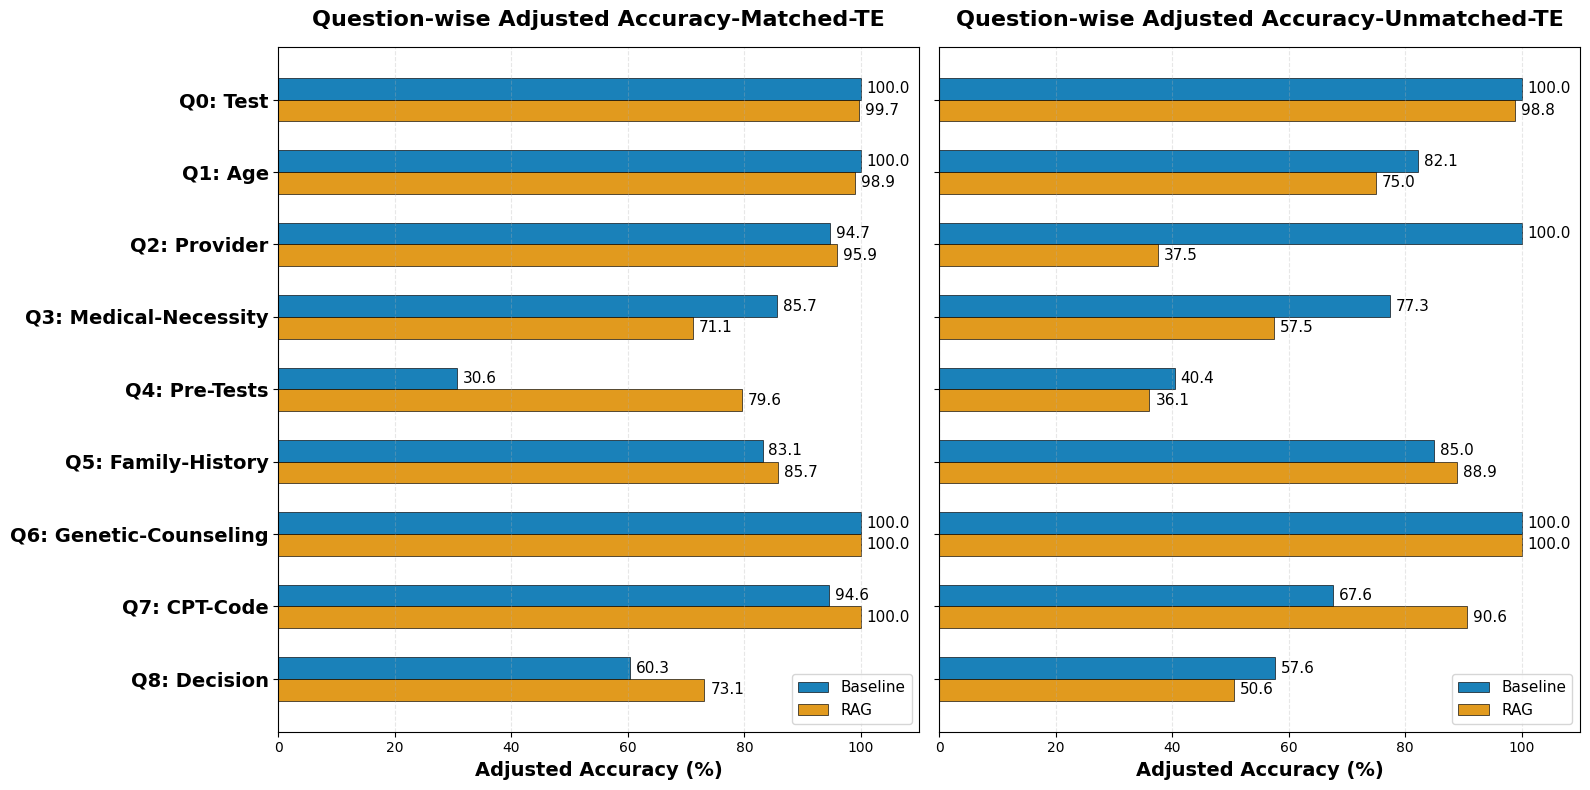

In [46]:
# Matched 데이터 (adjusted 버전 사용)
baseline_te_matched = [baseline_te_matched_both_adj_acc[q] for q in Questions]
rag_te_matched = [rag_te_matched_both_adj_acc[q] for q in Questions]
# Unmatched 데이터 (adjusted 버전 사용)
baseline_te_unmatched = [baseline_te_unmatched_both_adj_acc[q] for q in Questions]
rag_te_unmatched = [rag_te_unmatched_both_adj_acc[q] for q in Questions]
# Figure 생성
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# 왼쪽: Matched
y = np.arange(len(question_labels))
height = 0.3

bars1 = ax1.barh(y - height/2, baseline_te_matched, height, label='Baseline', 
                 color='#0173B2', alpha=0.9, edgecolor='black', linewidth=0.5)
bars2 = ax1.barh(y + height/2, rag_te_matched, height, label='RAG', 
                 color='#DE8F05', alpha=0.9, edgecolor='black', linewidth=0.5)

# 값 표시
for bars in [bars1, bars2]:
    for bar in bars:
        width = bar.get_width()
        ax1.text(width + 1, bar.get_y() + bar.get_height()/2.,
                f'{width:.1f}', ha='left', va='center', fontsize=11)

ax1.set_xlabel('Adjusted Accuracy (%)', fontsize=14, fontweight='bold')
ax1.set_title('Question-wise Adjusted Accuracy-Matched-TE', fontsize=16, fontweight='bold', pad=15)
ax1.set_yticks(y)
ax1.set_yticklabels(question_labels, fontsize=14, fontweight='bold')
ax1.legend(fontsize=11, loc='lower right')
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.set_xlim(0, 110)
ax1.invert_yaxis()

# 오른쪽: Unmatched
height_unmatched = 0.3

bars4 = ax2.barh(y - height_unmatched/2, baseline_te_unmatched, height_unmatched, 
                 label='Baseline', color='#0173B2', alpha=0.9, 
                 edgecolor='black', linewidth=0.5)
bars5 = ax2.barh(y + height_unmatched/2, rag_te_unmatched, height_unmatched, 
                 label='RAG', color='#DE8F05', alpha=0.9, 
                 edgecolor='black', linewidth=0.5)

# 값 표시
for bars in [bars4, bars5]:
    for bar in bars:
        width = bar.get_width()
        ax2.text(width + 1, bar.get_y() + bar.get_height()/2.,
                f'{width:.1f}', ha='left', va='center', fontsize=11)

ax2.set_xlabel('Adjusted Accuracy (%)', fontsize=14, fontweight='bold')
ax2.set_title('Question-wise Adjusted Accuracy-Unmatched-TE', fontsize=16, fontweight='bold', pad=15)
ax2.set_yticks(y)
ax2.set_yticklabels([])
ax2.legend(fontsize=11, loc='lower right')
ax2.grid(axis='x', alpha=0.3, linestyle='--')
ax2.set_xlim(0, 110)
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

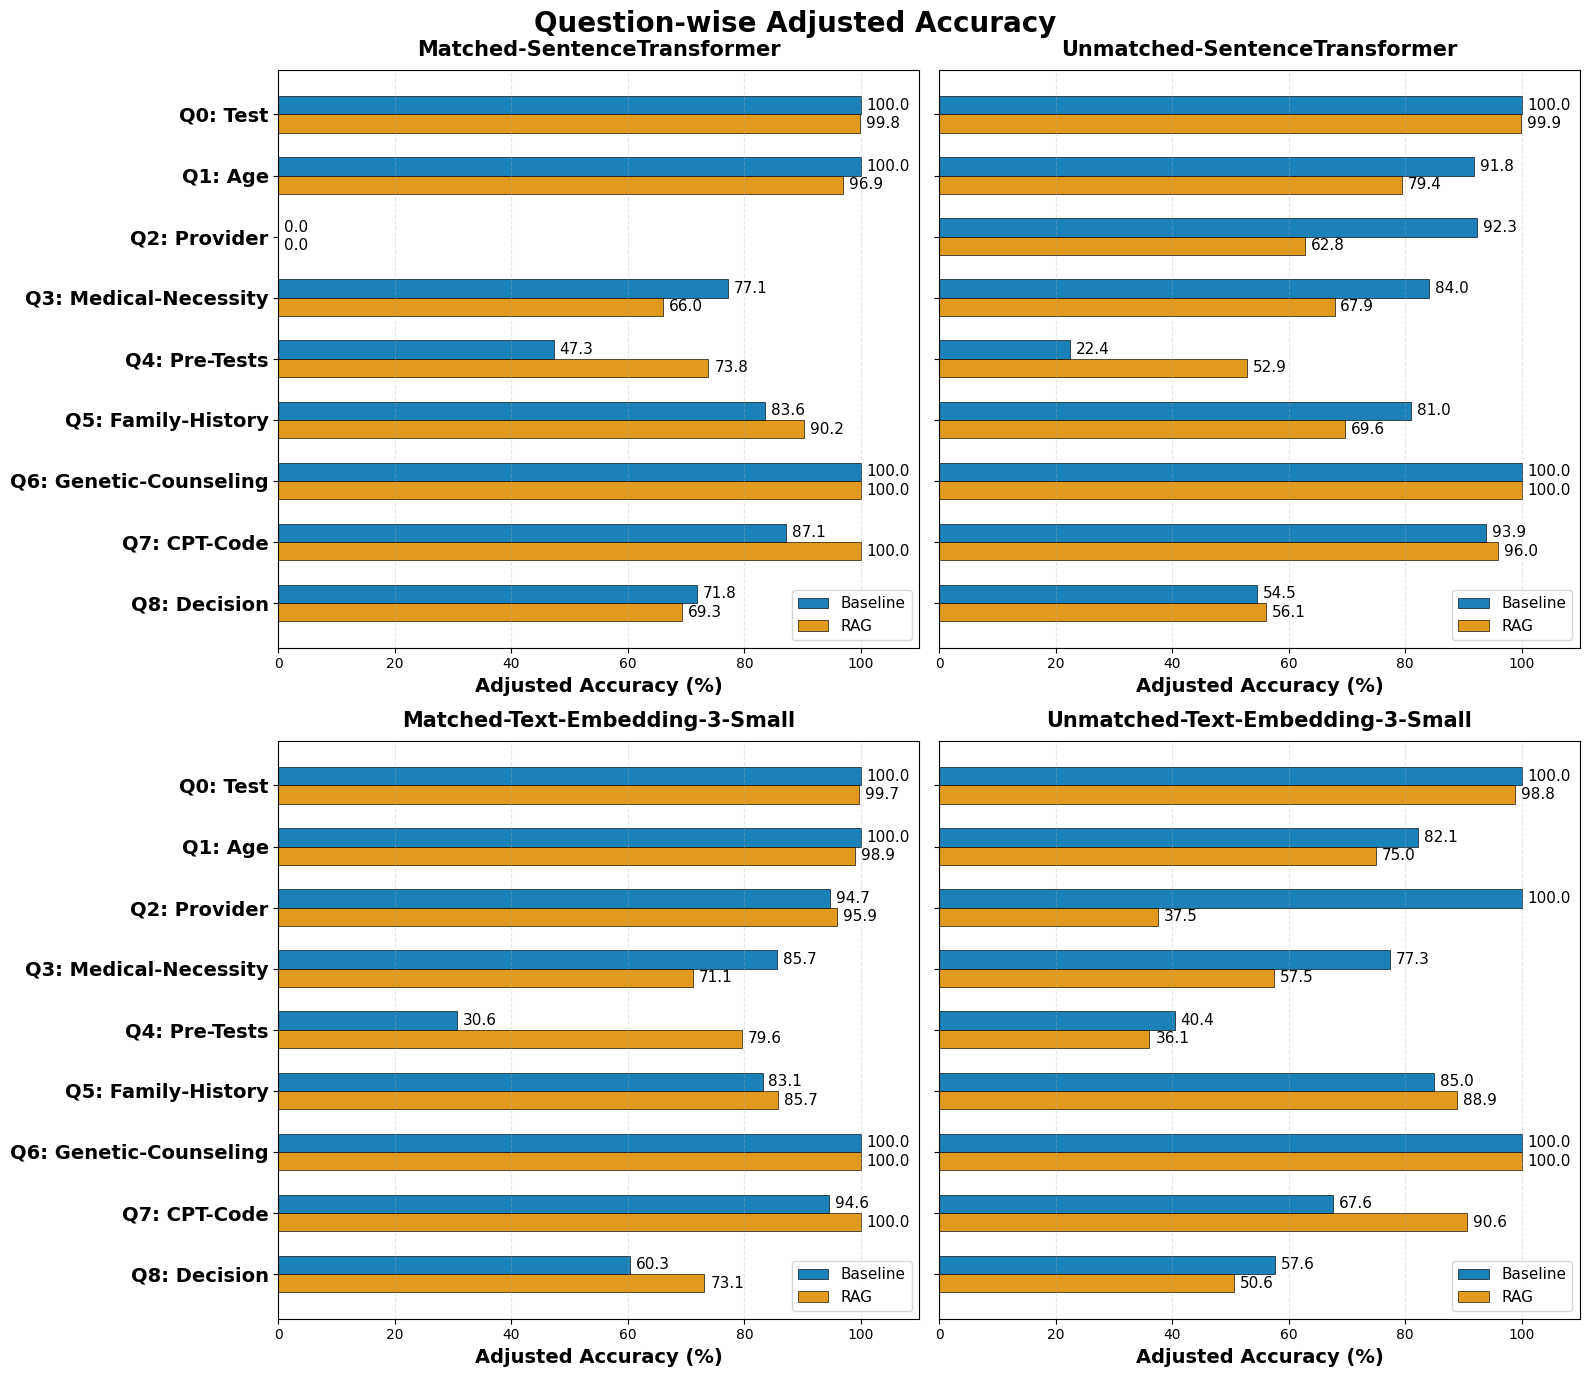

In [25]:
# 데이터 준비
baseline_matched = [baseline_matched_both_adj_acc[q] for q in Questions]
rag_matched = [rag_matched_both_adj_acc[q] for q in Questions]
baseline_unmatched_data = [baseline_unmatched_both_adj_acc[q] for q in Questions]
rag_unmatched_data = [rag_unmatched_both_adj_acc[q] for q in Questions]

baseline_te_matched = [baseline_te_matched_both_adj_acc[q] for q in Questions]
rag_te_matched = [rag_te_matched_both_adj_acc[q] for q in Questions]
baseline_te_unmatched = [baseline_te_unmatched_both_adj_acc[q] for q in Questions]
rag_te_unmatched = [rag_te_unmatched_both_adj_acc[q] for q in Questions]

# Figure 생성 (2x2)
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 전체 제목 추가
fig.suptitle('Question-wise Adjusted Accuracy', fontsize=20, fontweight='bold', y=0.98)

y = np.arange(len(question_labels))
height = 0.3

# 각 subplot 설정
plots_config = [
    (axes[0, 0], baseline_matched, rag_matched, 'Matched-SentenceTransformer', True),
    (axes[0, 1], baseline_unmatched_data, rag_unmatched_data, 'Unmatched-SentenceTransformer', False),
    (axes[1, 0], baseline_te_matched, rag_te_matched, 'Matched-Text-Embedding-3-Small', True),
    (axes[1, 1], baseline_te_unmatched, rag_te_unmatched, 'Unmatched-Text-Embedding-3-Small', False)
]

for ax, baseline_data, rag_data, title, show_ylabel in plots_config:
    # 막대 그래프
    bars1 = ax.barh(y - height/2, baseline_data, height, label='Baseline', 
                     color='#0173B2', alpha=0.9, edgecolor='black', linewidth=0.5)
    bars2 = ax.barh(y + height/2, rag_data, height, label='RAG', 
                     color='#DE8F05', alpha=0.9, edgecolor='black', linewidth=0.5)
    
    # 값 표시
    for bars in [bars1, bars2]:
        for bar in bars:
            width = bar.get_width()
            ax.text(width + 1, bar.get_y() + bar.get_height()/2.,
                    f'{width:.1f}', ha='left', va='center', fontsize=11)
    
    # 축 설정
    ax.set_xlabel('Adjusted Accuracy (%)', fontsize=14, fontweight='bold')
    ax.set_title(title, fontsize=15, fontweight='bold', pad=10)
    ax.set_yticks(y)
    if show_ylabel:
        ax.set_yticklabels(question_labels, fontsize=14, fontweight='bold')
    else:
        ax.set_yticklabels([])
    ax.legend(fontsize=11, loc='lower right')
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.set_xlim(0, 110)
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

In [47]:
def add_accuracy_column_exclude_both_notspecified(merged_csv_path, ground_truth_json_path, output_path):
    """Add accuracy columns to merged csv based on ground truth json"""
    
    df = pd.read_csv(merged_csv_path)
    
    with open(ground_truth_json_path, "r") as f:
        gt_data = json.load(f)
    
    Questions = ["Q0", "Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]
    
    accuracies = []
    corrects = []
    totals = []  # Now this will vary per case
    wrong_questions_list = []
    ground_truth_answers_list = []
    
    for _, row in df.iterrows():
        case_id = row["case_id"]
        gt_entry = gt_data.get(case_id)
        
        if not gt_entry:
            accuracies.append(None)
            corrects.append(None)
            totals.append(None)
            wrong_questions_list.append(None)
            ground_truth_answers_list.append(None)
            continue
        
        correct = 0
        total = 0
        wrong_qs = []  
        gt_answers = [] 

        q0_value = str(gt_entry.get("Q0", "")).strip()
        skip_q1 = (q0_value == "BRCA1/2")
        
        for q in Questions:
            true = str(gt_entry.get(q, "")).strip()
            
            # Skip if ground truth is "Not Specified"
            if true == "Not Specified":
                continue

            if q == "Q1" and skip_q1:
                continue
            
            pred = str(row.get(q, "")).strip()

            if pred == "Not Specified":
                continue
            
            if pred == true and pred != "":
                correct += 1
            else:
                # Record incorrect answer
                wrong_qs.append(q)
                gt_answers.append(f"{q}:{true}")
            
            total += 1
        
        acc = 100 * correct / total if total > 0 else 0
        accuracies.append(acc)
        corrects.append(correct)
        totals.append(total)
        
        # Convert lists to strings
        wrong_questions_list.append(",".join(wrong_qs) if wrong_qs else "")
        ground_truth_answers_list.append("|".join(gt_answers) if gt_answers else "")
    
    # Add new columns
    df['correct'] = corrects
    df['adjusted_total'] = totals  # Now variable per case
    df['adjusted_accuracy'] = accuracies
    df['wrong_questions'] = wrong_questions_list
    df['ground_truth'] = ground_truth_answers_list
    
    df.to_csv(output_path, index=False)
    print(f"Saved: {output_path}")
    
    return df

Saved: /home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/baseline_openai_header_combined_results_with_both_adjusted_accuracy.csv
Saved: /home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/openai_header_data_with_both_adjusted_accuracy.csv


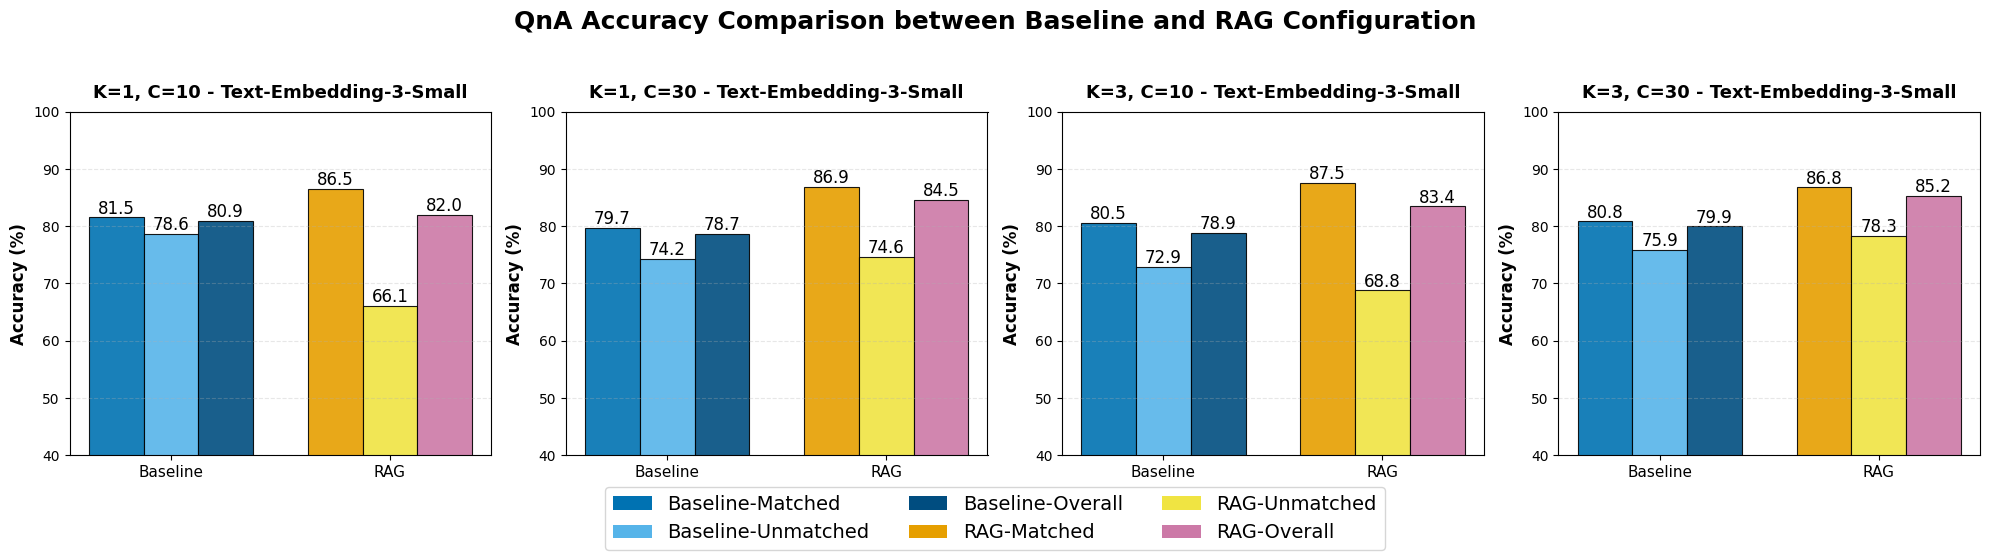

In [48]:

add_accuracy_column_exclude_both_notspecified(
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/baseline_openai_header_combined_results.csv',
    ground_truth_json_path,
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/baseline_openai_header_combined_results_with_both_adjusted_accuracy.csv'
)

add_accuracy_column_exclude_both_notspecified(
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/openai_header_data.csv',
    ground_truth_json_path,
    '/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/openai_header_data_with_both_adjusted_accuracy.csv'
) 

df_baseline_te = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/baseline_openai_header_combined_results_with_both_adjusted_accuracy.csv')
df_openai_header = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/openai_header_data_with_both_adjusted_accuracy.csv')

df_baseline_te_filtered = df_baseline_te[(df_baseline_te['qna_model'] == 'gpt_5_mini') & (df_baseline_te['retrieval_model'] == 'gpt_5_mini')]

configs = ['K=1, C=10', 'K=1, C=30', 'K=3, C=10', 'K=3, C=30']
config_params = [
    {'top_k': 1, 'retrieval_count': 10},
    {'top_k': 1, 'retrieval_count': 30},
    {'top_k': 3, 'retrieval_count': 10},
    {'top_k': 3, 'retrieval_count': 30}
]

te_baseline_matched = []
te_baseline_unmatched = []
te_baseline_overall = []
te_rag_matched = []
te_rag_unmatched = []
te_rag_overall = []

for params in config_params:
    # Baseline
    b = df_baseline_te_filtered[(df_baseline_te_filtered['top_k'] == params['top_k']) & (df_baseline_te_filtered['retrieval_count'] == params['retrieval_count'])]
    te_baseline_matched.append(b[b['match'] == 1]['adjusted_accuracy'].mean())
    te_baseline_unmatched.append(b[b['match'] == 0]['adjusted_accuracy'].mean())
    te_baseline_overall.append(b['adjusted_accuracy'].mean())
    
    # RAG
    r = df_openai_header[(df_openai_header['top_k'] == params['top_k']) & (df_openai_header['retrieval_count'] == params['retrieval_count'])]
    te_rag_matched.append(r[r['match'] == 1]['adjusted_accuracy'].mean())
    te_rag_unmatched.append(r[r['match'] == 0]['adjusted_accuracy'].mean())
    te_rag_overall.append(r['adjusted_accuracy'].mean())

# Figure 생성 (4개 subplot - Text-Embedding-3-Small만)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # 1행 4열로 변경
axes = axes.flatten()

# Color blind friendly colors
colors_baseline = ['#0072B2', '#56B4E9', '#004D80']  # 파란색 계열
colors_internal = ['#E69F00', '#F0E442', '#CC79A7']  # 주황/노랑/보라 계열

for idx in range(4):  # 4개만 반복
    ax = axes[idx]
    config = configs[idx]
    x = np.arange(2)
    width = 0.25
    
    # Text-Embedding-3-Small 데이터만 사용
    baseline_data = [te_baseline_matched[idx], te_baseline_unmatched[idx], te_baseline_overall[idx]]
    internal_data = [te_rag_matched[idx], te_rag_unmatched[idx], te_rag_overall[idx]]
    title = f'{config} - Text-Embedding-3-Small'
    
    # Baseline bars (파란색 계열)
    for i, (value, color) in enumerate(zip(baseline_data, colors_baseline)):
        offset = (i - 1) * width
        bar = ax.bar(0 + offset, value, width, color=color, alpha=0.9, edgecolor='black', linewidth=0.8)
        ax.text(0 + offset, value, f'{value:.1f}', ha='center', va='bottom', fontsize=12)
    
    # Internal-QA bars (주황색 계열)
    for i, (value, color) in enumerate(zip(internal_data, colors_internal)):
        offset = (i - 1) * width
        bar = ax.bar(1 + offset, value, width, color=color, alpha=0.9, edgecolor='black', linewidth=0.8)
        ax.text(1 + offset, value, f'{value:.1f}', ha='center', va='bottom', fontsize=12)
    
    ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold', pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(['Baseline', 'RAG'], fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim(40, 100)  # y축 범위 조정

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#0072B2', label='Baseline-Matched'),
    Patch(facecolor='#56B4E9', label='Baseline-Unmatched'),
    Patch(facecolor='#004D80', label='Baseline-Overall'),
    Patch(facecolor='#E69F00', label='RAG-Matched'),
    Patch(facecolor='#F0E442', label='RAG-Unmatched'),
    Patch(facecolor='#CC79A7', label='RAG-Overall')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=14, bbox_to_anchor=(0.5, -0.08))

plt.suptitle('QnA Accuracy Comparison between Baseline and RAG Configuration', 
             fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0, 0.05, 1, 0.98])
#plt.savefig('/mnt/user-data/outputs/text_embedding_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
